In [ ]:
# default_exp benchmark.traceability

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Traceability Benchmark

> This module is dedicated benchmarking traceability related projects

In [ ]:
#export
# Imports
import logging
import gensim

import matplotlib.pyplot as plt
import pandas as pd
import sentencepiece as sp
import numpy as np

from collections import Counter

# ds4se
from ds4se.mgmnt.prep.traceability import *
from ds4se.mgmnt.prep.nltk import *
from ds4se.mgmnt.prep.bpe import *
from ds4se.benchmark.i import *
from ds4se.exp.info import *
from ds4se.desc.stats import *
from ds4se.vis import *

from pathlib import Path

unable to import 'smart_open.gcs', disabling that module


In [ ]:
#export
logger = logging.getLogger(__name__)
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
# export
def inferDoc2Vec(df, model, col_order):
    df_inferred = df.copy()
    df_inferred['src_vec'] =  [
        model.infer_vector(artifact.split(), steps=200) for artifact in df_inferred['src_doc'].values
    ]
    df_inferred['trgt_vec'] =  [
        model.infer_vector(artifact.split(), steps=200) for artifact in df_inferred['trgt_doc'].values
    ]
    
    df_inferred = df_inferred[col_order]
    return df_inferred

In [ ]:
# From: https://stackoverflow.com/a/30930895/5768407
def makeArray(text):
    return np.fromstring(text[1:-1],sep=' ')

In [ ]:
def add_tok_docs(nltk_df, df, col_order):
    src_docs, trgt_docs = get_nltk_docs(
        nltk_df, df.src_file.values, df.trgt_file.values
    )
    df['src_doc'] = src_docs
    df['trgt_doc'] = trgt_docs
    
    df = df[col_order]
    return df

In [ ]:
def add_nltk_tok_docs(nltk_df, df):
    src_docs, trgt_docs = get_nltk_docs(
        nltk_df, df.src_file.values, df.trgt_file.values
    )
    df['src_doc'] = src_docs
    df['trgt_doc'] = trgt_docs
    
    df = df[['src_dtype', 'trgt_dtype','src_file', 'trgt_file', 'src_doc', 'trgt_doc', 'wmd']]
    return df

In [ ]:
def add_groundtruth(path, df, links):
    df['ground_truth'] = [0] * len(df)
    for i in range(len(df)):
        src_file = str(Path(df.iloc[i].src_file).name).replace('-pre', '')
        trgt_file = str(Path(df.iloc[i].trgt_file).name).replace('-pre', '')
        for j in range(len(links)):
            if str(links.iloc[j].src_file) == src_file:
                if str(links.iloc[j].trgt_file) == trgt_file:
                    df.at[i, 'ground_truth'] = 1
    
    return df

In [ ]:
path = Path('../benchmarking/traceability/testbeds'); list(path.glob('*'))
sys = 'libest'
req_df = pd.read_csv(path/f'nltk/[{sys}-pre-req].csv', header = None, names = ['file', 'text'], delimiter = ' ')
src_df = pd.read_csv(path/f'nltk/[{sys}-pre-src].csv', header = None, names = ['file', 'text'], delimiter = ' ')
tc_df = pd.read_csv(path/f'nltk/[{sys}-pre-tc].csv', header = None, names = ['file', 'text'], delimiter = ' ')
# Concat df into a single df of the system
nltk_df = pd.concat([req_df, src_df, tc_df]).reset_index(drop = True)
nltk_df['file'] = nltk_df['file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
nltk_df.head()

,file,text
0,RQ17.txt,requir http uri control est server must suppor...
1,RQ46.txt,requir server side key generat respons request...
2,RQ18.txt,requir http base client authent est server may...
3,RQ48.txt,requir csr attribut request est client request...
4,RQ42.txt,requir server side key generat est client may ...


In [ ]:
path = Path('test_data')
doc2vec_model = gensim.models.Doc2Vec.load("test_data/models/doc2vec_libest.model")
req2tc_doc2vec_df = pd.read_csv(
    path/'[libest-req2tc-filter_doc2vec-1589937858.183836].csv',
    header = None, names = ['src_file', 'trgt_file', 'cos', 'sim_wmd', 'ground_truth'],
    delimiter = ' '
)
req2tc_doc2vec_df['src_file'] = req2tc_doc2vec_df['src_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2tc_doc2vec_df['src_dtype'] = ['req'] * len(req2tc_doc2vec_df)
req2tc_doc2vec_df['trgt_file'] = req2tc_doc2vec_df['trgt_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2tc_doc2vec_df['trgt_dtype'] = ['tc'] * len(req2tc_doc2vec_df)
req2tc_doc2vec_df = add_tok_docs(
    nltk_df, req2tc_doc2vec_df,
    col_order = req2tc_doc2vec_df.columns
)

req2tc_doc2vec_df = inferDoc2Vec(
    req2tc_doc2vec_df, doc2vec_model,
    col_order = [
        'src_dtype', 'trgt_dtype',
        'src_file', 'trgt_file',
        'src_doc', 'trgt_doc', 'cos',
        'sim_wmd', 'src_vec', 'trgt_vec',
        'ground_truth'
    ]
)
req2tc_doc2vec_df.head()

05/20/2020 21:15:19 - INFO - gensim.utils -   loading Doc2Vec object from test_data/models/doc2vec_libest.model
05/20/2020 21:15:19 - INFO - gensim.utils -   loading vocabulary recursively from test_data/models/doc2vec_libest.model.vocabulary.* with mmap=None
05/20/2020 21:15:19 - INFO - gensim.utils -   loading trainables recursively from test_data/models/doc2vec_libest.model.trainables.* with mmap=None
05/20/2020 21:15:19 - INFO - gensim.utils -   loading wv recursively from test_data/models/doc2vec_libest.model.wv.* with mmap=None
05/20/2020 21:15:19 - INFO - gensim.utils -   loading docvecs recursively from test_data/models/doc2vec_libest.model.docvecs.* with mmap=None
05/20/2020 21:15:19 - INFO - gensim.utils -   loaded test_data/models/doc2vec_libest.model


,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,cos,sim_wmd,src_vec,trgt_vec,groundtruth
0,req,tc,RQ17.txt,us903.c,requir http uri control est server must suppor...,unit test user stori server simpl enrol august...,0.777684,0.222316,"[-2.8299713, -2.417891, -6.4768066, 3.0046458,...","[-1.1459221, -0.7096575, -3.8471947, -6.552199...",0.0
1,req,tc,RQ17.txt,us3496.c,requir http uri control est server must suppor...,unit test uri path segment extens support marc...,0.540987,0.459013,"[-2.8026786, -2.3817642, -6.5540066, 2.9981785...","[-7.809855, -3.0506206, -2.1036313, 0.524558, ...",0.0
2,req,tc,RQ17.txt,us899.c,requir http uri control est server must suppor...,unit test user stori client simpl enrol septem...,0.760152,0.239848,"[-2.5521355, -2.36984, -6.516166, 2.7940185, -...","[-2.4905083, -1.7894417, -2.435723, -1.7207395...",0.0
3,req,tc,RQ17.txt,us4020.c,requir http uri control est server must suppor...,unit test user stori unit test client proxi mo...,0.855632,0.144368,"[-2.7679605, -2.3731954, -6.3415036, 2.8737454...","[-5.589645, -0.017446352, 2.548506, -0.8260442...",0.0
4,req,tc,RQ17.txt,us897.c,requir http uri control est server must suppor...,unit test user stori client cacert june copyri...,0.531414,0.468586,"[-2.63832, -2.5851905, -6.3675537, 2.899605, -...","[-5.5864563, -4.070523, -4.2604833, -0.2996092...",0.0


In [ ]:
req2tc_doc2vec_df.to_csv('/tf/main/benchmarking/traceability/testbeds/nltk/libest_req2tc_doc2vec.csv', index=False)

In [ ]:
path = Path('/tf/main/benchmarking/traceability/testbeds/nltk')
req2tc_doc2vec_df = pd.read_csv(path/'libest_req2tc_doc2vec.csv')
req2tc_doc2vec_df['src_vec'] = req2tc_doc2vec_df['src_vec'].apply(makeArray)
req2tc_doc2vec_df['trgt_vec'] = req2tc_doc2vec_df['trgt_vec'].apply(makeArray)
req2tc_doc2vec_df.head()

,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,cos,sim_wmd,src_vec,trgt_vec,ground_truth
0,req,tc,RQ17.txt,us903.c,requir http uri control est server must suppor...,unit test user stori server simpl enrol august...,0.777684,0.222316,"[-2.8299713, -2.417891, -6.4768066, 3.0046458,...","[-1.1459221, -0.7096575, -3.8471947, -6.552199...",0
1,req,tc,RQ17.txt,us3496.c,requir http uri control est server must suppor...,unit test uri path segment extens support marc...,0.540987,0.459013,"[-2.8026786, -2.3817642, -6.5540066, 2.9981785...","[-7.809855, -3.0506206, -2.1036313, 0.524558, ...",0
2,req,tc,RQ17.txt,us899.c,requir http uri control est server must suppor...,unit test user stori client simpl enrol septem...,0.760152,0.239848,"[-2.5521355, -2.36984, -6.516166, 2.7940185, -...","[-2.4905083, -1.7894417, -2.435723, -1.7207395...",0
3,req,tc,RQ17.txt,us4020.c,requir http uri control est server must suppor...,unit test user stori unit test client proxi mo...,0.855632,0.144368,"[-2.7679605, -2.3731954, -6.3415036, 2.8737454...","[-5.589645, -0.01744635, 2.548506, -0.8260442,...",0
4,req,tc,RQ17.txt,us897.c,requir http uri control est server must suppor...,unit test user stori client cacert june copyri...,0.531414,0.468586,"[-2.63832, -2.5851905, -6.3675537, 2.899605, -...","[-5.5864563, -4.07052279, -4.26048326, -0.2996...",0


In [ ]:
path = Path('/tf/main/benchmarking/traceability/testbeds/nltk')
req2src_word2vec_df = pd.read_csv(path/'libest_req2src.csv')
req2src_word2vec_df['src_vec'] = req2src_word2vec_df['src_vec'].apply(makeArray)
req2src_word2vec_df['trgt_vec'] = req2src_word2vec_df['trgt_vec'].apply(makeArray)
req2src_word2vec_df.head()

,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,src_vec,trgt_vec,wmd,ground_truth
0,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est.h,requir server key generat follow exampl valid ...,file est est public api enrol secur transport ...,"[0.00314126, -0.11988081, -0.28746873, 0.01172...","[-0.01909254, -0.12634756, -0.2693117, 0.01079...",0.340562,0
1,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir certif less tls mutual authent certif l...,static pthread pthread self void return get cu...,"[0.03502419, -0.11070093, -0.26910967, 0.00777...","[-0.01663938, -0.12135821, -0.279722, 0.009708...",0.410977,0
2,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir client use implicit databas est client ...,prototyp privat est server part public api voi...,"[0.02980203, -0.11710332, -0.26550922, 0.00489...","[-0.03448066, -0.14800207, -0.26153752, 0.0186...",0.386474,0
3,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir inform refer idev ieee standard associ ...,libest test api void est log est log level lvl...,"[0.01319338, -0.11533403, -0.2819848, 0.009903...","[-0.04279312, -0.12860508, -0.2682275, 0.00651...",0.447825,0
4,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir tls client authent recommend method ide...,tcw err tcw connect tcw sock sock tcw opt opt ...,"[0.03560031, -0.11806617, -0.2603899, 0.008908...","[-0.02559054, -0.11442585, -0.285615, 0.005884...",0.532702,0


In [ ]:
# export
class TraceabilityTestbed(Testbed):
    def __init__(self, traces, col_metric):
        Testbed.__init__(self, traces.copy())
        self.data = self.data.rename(columns={col_metric: 'link_metric'})
        
    def get_ground_truth(self):
        return self.data.loc[self.data.ground_truth == 1]
    
    def get_non_ground_truth(self):
        return self.data.loc[self.data.ground_truth == 0]
        
    def __getitem__(self, idx):
        return self.data.iloc[idx]
    
    def evaluate(self, inpt):
        pass

In [ ]:
entropy_traces_req2tc_doc2vec_tstbd = TraceabilityTestbed(req2tc_doc2vec_df, 'cos')
entropy_traces_req2tc_doc2vec_tstbd[0]

src_dtype                                                     req
trgt_dtype                                                     tc
src_file                                                 RQ17.txt
trgt_file                                                 us903.c
src_doc         requir http uri control est server must suppor...
trgt_doc        unit test user stori server simpl enrol august...
link_metric                                              0.777684
sim_wmd                                                  0.222316
src_vec         [-2.8299713, -2.417891, -6.4768066, 3.0046458,...
trgt_vec        [-1.1459221, -0.7096575, -3.8471947, -6.552199...
ground_truth                                                    0
Name: 0, dtype: object

In [ ]:
entropy_traces_req2src_word2vec_tstbd = TraceabilityTestbed(req2src_word2vec_df, 'wmd')
entropy_traces_req2src_word2vec_tstbd[0]

src_dtype                                                     req
trgt_dtype                                                    src
src_file        test_data/LibEST_semeru_format/requirements/RQ...
trgt_file        test_data/LibEST_semeru_format/source_code/est.h
src_doc         requir server key generat follow exampl valid ...
trgt_doc        file est est public api enrol secur transport ...
src_vec         [0.00314126, -0.11988081, -0.28746873, 0.01172...
trgt_vec        [-0.01909254, -0.12634756, -0.2693117, 0.01079...
link_metric                                              0.340562
ground_truth                                                    0
Name: 0, dtype: object

In [ ]:
# export
class TraceabilityProcedure(Procedure):
    def __init__(self, metrics, vocab):
        self.vocab = vocab
        Procedure.__init__(self, metrics)
    
    def evaluate(self, inpt):
        self.metrics['src_entropies'] = get_entropies_from_docs(inpt.src_doc.values, self.vocab)
        self.metrics['trgt_entropies'] = get_entropies_from_docs(inpt.trgt_doc.values, self.vocab)
        logging.info("Finished calculating document level entropies")
        
        all_docs = inpt.src_doc.values + inpt.trgt_doc.values
        self.metrics['tot_entropy'] = get_entropy_from_docs(all_docs, self.vocab)
        logging.info("Finished calculating corpus level entropy")
        
        self.metrics['shared_entropy'] = shared_entropy_from_docs(
            (inpt.src_doc.values, inpt.trgt_doc.values), self.vocab
        )
        logging.info("Finished calculating corpus level shared entropy")
        self.metrics['shared_probs'] = [get_shared_probs_from_docs([[docs[0]], [docs[1]]], self.vocab)[0] for docs in zip(inpt.src_doc.values, inpt.trgt_doc.values)]
        
        get_shared_probs_from_docs(
            (inpt.src_doc.values, inpt.trgt_doc.values), self.vocab
        )[0]
        logging.info("Finished calculating corpus level shared relative probabilities")
        
        return self.metrics

In [ ]:
path = Path('../benchmarking/traceability/testbeds')
with open(path/f'nltk/[libest-vocab-all].csv', 'r') as f:
    nltk_vocab = f.read().splitlines()

len(nltk_vocab), nltk_vocab[:10]

(5332,
 ['""',
  'draft',
  'd8g0th6gs2h',
  'bsfluvm',
  'cgi',
  'miidoayjko',
  'cb0a',
  'ede',
  'revok',
  'w91ia0kssdt'])

In [ ]:
metrics = {}
trace_procedure = TraceabilityProcedure(metrics, nltk_vocab)
# metrics = trace_procedure.evaluate(entropy_traces_tstbd.data, nltk_vocab)

In [ ]:
# export
class TraceabilityBenchmark(Benchmark):
    def __init__(self, testbed, procedure):
        self.testbed = testbed
        self.ground_truth = testbed.get_ground_truth()
        self.non_ground_truth = testbed.get_non_ground_truth()
        self.procedure = procedure
        
        self.src_dtype = self.ground_truth.iloc[0].src_dtype
        self.trgt_dtype = self.ground_truth.iloc[0].trgt_dtype
        Benchmark.__init__(self, testbed, procedure)
    
    def visualize(self):
        min_len = min(len(self.ground_truth), len(self.non_ground_truth))
        src_dtype = self.ground_truth.iloc[0].src_dtype
        trgt_dtype = self.ground_truth.iloc[0].trgt_dtype
        
        gt_src_vecs = np.stack(self.ground_truth.src_vec.to_list())[:min_len]
        gt_trgt_vecs = np.stack(self.ground_truth.trgt_vec.to_list())[:min_len]
        gt_src_entropies = self.ground_truth_metrics['src_entropies'][:min_len]
        gt_trgt_entropies = self.ground_truth_metrics['trgt_entropies'][:min_len]
        gt_shared_probs = self.ground_truth_metrics['shared_probs'][:min_len]
        gt_link_metric = self.ground_truth.link_metric.values[:min_len]
        
        ngt_src_vecs = np.stack(self.non_ground_truth.src_vec.to_list())[:min_len]
        ngt_trgt_vecs = np.stack(self.non_ground_truth.trgt_vec.to_list())[:min_len]
        ngt_src_entropies = self.non_ground_truth_metrics['src_entropies'][:min_len]
        ngt_trgt_entropies = self.non_ground_truth_metrics['trgt_entropies'][:min_len]
        ngt_shared_probs = self.non_ground_truth_metrics['shared_probs'][:min_len]
        ngt_link_metric = self.non_ground_truth.link_metric.values[:min_len]
        logging.info(f'Clusterization for {self.src_dtype}')
        clusterize_w_entropy(gt_src_vecs, ngt_src_vecs, gt_src_entropies, ngt_src_entropies)
        logging.info(f'Clusterization for {self.trgt_dtype}')
        clusterize_w_entropy(gt_trgt_vecs, ngt_trgt_vecs, gt_trgt_entropies, ngt_trgt_entropies)
        visualize_events(gt_shared_probs, 'b', f'libest-{self.trgt_dtype}', 'groundtruth')
        visualize_events(ngt_shared_probs, 'r', f'libest-{self.trgt_dtype}', 'non-groundtruth')
        vis_3d(
            [gt_src_entropies, gt_trgt_entropies, gt_link_metric],
            [ngt_src_entropies, ngt_trgt_entropies, ngt_link_metric],
            src_dtype, trgt_dtype
        )
    
    def gen_report(self):
        print(f'Descriptive Statistics for Groundtruth {self.src_dtype}')
        report_stats(self.ground_truth_metrics['src_entropies'])
        print()
        print(f'Descriptive Statistics for Groundtruth {self.trgt_dtype}')
        report_stats(self.ground_truth_metrics['trgt_entropies'])
        print()
        
        print(f'Descriptive Statistics for Groundtruth {self.src_dtype}')
        report_stats(self.non_ground_truth_metrics['src_entropies'])
        print()
        print(f'Descriptive Statistics for Groundtruth {self.trgt_dtype}')
        report_stats(self.non_ground_truth_metrics['trgt_entropies'])
        print()
#         pass
    
    def evaluate(self):
        self.ground_truth_metrics = self.procedure.evaluate(self.ground_truth)
        self.non_ground_truth_metrics = self.procedure.evaluate(self.non_ground_truth)

In [ ]:
entropy_trace_req2tc_doc2vec_benchmark = TraceabilityBenchmark(entropy_traces_req2tc_doc2vec_tstbd, trace_procedure)
entropy_trace_req2src_word2vec_benchmark = TraceabilityBenchmark(entropy_traces_req2src_word2vec_tstbd, trace_procedure)

In [ ]:
# entropy_trace_req2tc_doc2vec_benchmark.evaluate()
# ground_truth_metrics = entropy_trace_req2tc_doc2vec_benchmark.ground_truth_metrics
# non_ground_truth_metrics = entropy_trace_req2tc_doc2vec_benchmark.non_ground_truth_metrics
entropy_trace_req2tc_doc2vec_benchmark.ground_truth_metrics = ground_truth_metrics
entropy_trace_req2tc_doc2vec_benchmark.non_ground_truth_metrics = non_ground_truth_metrics

05/21/2020 22:52:34 - INFO - root -   Clusterization for req


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 352 samples in 0.001s...
[t-SNE] Computed neighbors for 352 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 352 / 352
[t-SNE] Mean sigma: 7.842054
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.011696
[t-SNE] KL divergence after 300 iterations: 0.303633
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 352 samples in 0.001s...
[t-SNE] Computed neighbors for 352 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 352 / 352
[t-SNE] Mean sigma: 7.985724
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.010963
[t-SNE] KL divergence after 300 iterations: 0.185077


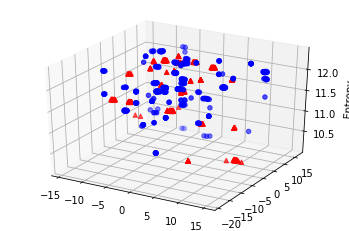

05/21/2020 22:52:35 - INFO - root -   Clusterization for tc


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 352 samples in 0.002s...
[t-SNE] Computed neighbors for 352 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 352 / 352
[t-SNE] Mean sigma: 14.347938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.022598
[t-SNE] KL divergence after 300 iterations: 0.070178
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 352 samples in 0.001s...
[t-SNE] Computed neighbors for 352 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 352 / 352
[t-SNE] Mean sigma: 13.836461
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.252003
[t-SNE] KL divergence after 300 iterations: 0.114719


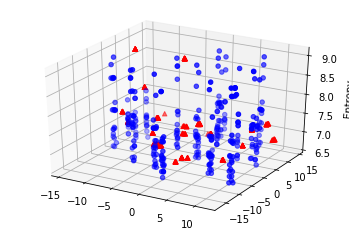

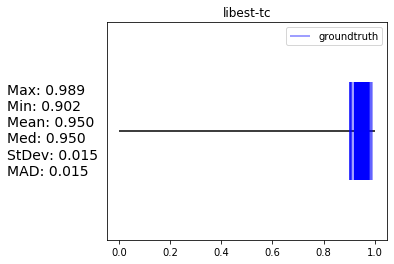

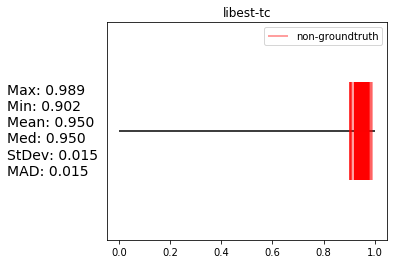

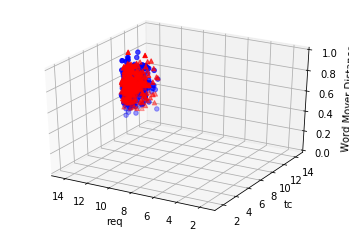

In [ ]:
entropy_trace_req2tc_doc2vec_benchmark.visualize()

In [ ]:
entropy_trace_req2src_word2vec_benchmark.evaluate()
# ground_truth_metrics = entropy_trace_req2src_word2vec_benchmark.ground_truth_metrics
# non_ground_truth_metrics = entropy_trace_req2src_word2vec_benchmark.non_ground_truth_metrics
# entropy_trace_req2src_word2vec_benchmark.ground_truth_metrics = ground_truth_metrics
# entropy_trace_req2src_word2vec_benchmark.non_ground_truth_metrics = non_ground_truth_metrics

In [ ]:
entropy_trace_req2src_word2vec_benchmark.visualize()

In [ ]:
entropy_traces_req2src_tstbd = TraceabilityTestbed(req2src)
trace_procedure = TraceabilityProcedure(metrics, nltk_vocab)
entropy_trace_req2src_benchmark = TraceabilityBenchmark(entropy_traces_req2src_tstbd, trace_procedure)
# entropy_trace_req2src_benchmark.evaluate()

In [ ]:
# ground_truth_metrics = entropy_trace_req2src_benchmark.ground_truth_metrics
# non_ground_truth_metrics = entropy_trace_req2src_benchmark.non_ground_truth_metrics

In [ ]:
entropy_trace_req2src_benchmark.ground_truth_metrics = ground_truth_metrics
entropy_trace_req2src_benchmark.non_ground_truth_metrics = non_ground_truth_metrics

05/03/2020 19:37:27 - INFO - root -   Clusterization for req


[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.001s...
[t-SNE] Computed neighbors for 30 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.553436
[t-SNE] KL divergence after 300 iterations: 0.753779
[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.000s...
[t-SNE] Computed neighbors for 30 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.831650
[t-SNE] KL divergence after 300 iterations: 0.530678


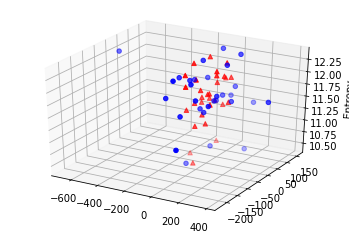

05/03/2020 19:37:28 - INFO - root -   Clusterization for src


[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.000s...
[t-SNE] Computed neighbors for 30 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.922081
[t-SNE] KL divergence after 300 iterations: 0.578991
[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.000s...
[t-SNE] Computed neighbors for 30 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.277802
[t-SNE] KL divergence after 300 iterations: 0.617913


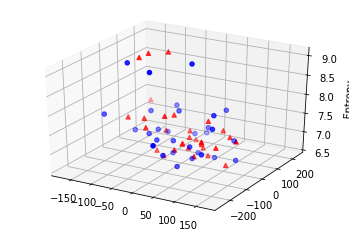

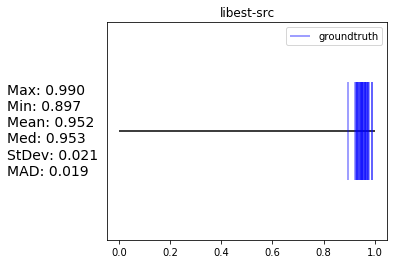

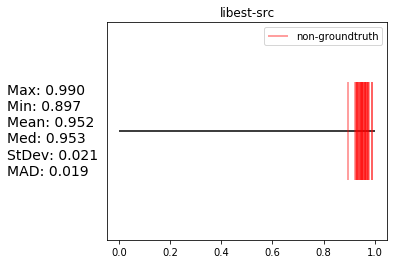

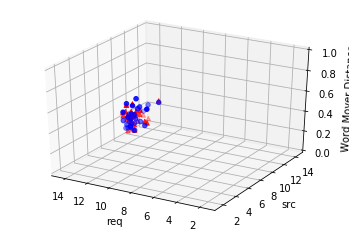

In [ ]:
entropy_trace_req2src_benchmark.visualize()

In [ ]:
entropy_trace_req2src_benchmark.gen_report()

Descriptive Statistics for Groundtruth req
Max: 12.352784142157043
Min: 9.964941153614443
Average: 11.678869718770434
Median: 11.86948157719435
Standard Deviation: 0.6439173152477431
Median Absolute Deviation: 0.46139409460359326
95% of the data fall within 11.634865977390158 and 11.72287346015071

Descriptive Statistics for Groundtruth src
Max: 9.03055398179956
Min: 6.611696965991226
Average: 7.4137525135883235
Median: 7.18719625826463
Standard Deviation: 0.6557157316938668
Median Absolute Deviation: 0.6042047331327329
95% of the data fall within 7.368942497157357 and 7.45856253001929

Descriptive Statistics for Groundtruth req
Max: 12.352784142157043
Min: 9.964941153614443
Average: 11.678869718770434
Median: 11.86948157719435
Standard Deviation: 0.6439173152477431
Median Absolute Deviation: 0.46139409460359326
95% of the data fall within 11.634865977390158 and 11.72287346015071

Descriptive Statistics for Groundtruth src
Max: 9.03055398179956
Min: 6.611696965991226
Average: 7.4137525

In [ ]:
req2tc = pd.read_csv(path/'nltk/libest_req2tc.csv')
req2tc['src_vec'] = req2tc['src_vec'].apply(makeArray)
req2tc['trgt_vec'] = req2tc['trgt_vec'].apply(makeArray)
req2tc.head()

,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,src_vec,trgt_vec,wmd,ground_truth
0,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,requir full pki request messag full pki reques...,unit test uri path segment extens support marc...,"[0.03035533, -0.11383446, -0.26580575, 0.00432...","[-0.03977351, -0.14905816, -0.25422758, 0.0321...",0.533299,0
1,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1005.c,requir terminolog key word must must requir sh...,unit test user stori client easi provis novemb...,"[0.0207649991, -0.123978503, -0.267159611, 0.0...","[-0.01134932, -0.12563385, -0.2688628, 0.01235...",0.334297,0
2,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,requir request asymmetr encrypt privat key spe...,unit test user stori tls srp support server pr...,"[-0.01903737, -0.15851521, -0.2653666, 0.03420...","[-0.00451687, -0.11426209, -0.27722117, 0.0099...",0.304404,0
3,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us895.c,requir tls client authent recommend method ide...,unit test user stori proxi csr attribut novemb...,"[0.03560031, -0.11806617, -0.2603899, 0.008908...","[-0.00619808, -0.09637509, -0.24735866, 0.0112...",0.618677,1
4,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,requir iana consider section defin oid regist ...,unit test user stori tls srp support server pr...,"[0.01455077, -0.11760523, -0.27798823, 0.00936...","[-0.00451687, -0.11426209, -0.27722117, 0.0099...",0.234525,0


In [ ]:
entropy_traces_req2tc_tstbd = TraceabilityTestbed(req2tc)
trace_procedure = TraceabilityProcedure(metrics, nltk_vocab)
entropy_trace_req2tc_benchmark = TraceabilityBenchmark(entropy_traces_req2tc_tstbd, trace_procedure)
entropy_trace_req2tc_benchmark.evaluate()

04/29/2020 18:48:35 - INFO - root -   Finished calculating document level entropies


04/29/2020 18:48:39 - INFO - root -   Finished calculating corpus level entropy


04/29/2020 18:49:15 - INFO - root -   Finished calculating corpus level shared entropy


04/29/2020 18:49:48 - INFO - root -   Finished calculating corpus level shared relative probabilities


04/29/2020 19:01:27 - INFO - root -   Finished calculating document level entropies


04/29/2020 19:01:34 - INFO - root -   Finished calculating corpus level entropy


04/29/2020 19:02:16 - INFO - root -   Finished calculating corpus level shared entropy


04/29/2020 19:03:32 - INFO - root -   Finished calculating corpus level shared relative probabilities


In [ ]:
# ground_truth_metrics = entropy_trace_req2tc_benchmark.ground_truth_metrics
# non_ground_truth_metrics = entropy_trace_req2tc_benchmark.non_ground_truth_metrics

In [ ]:
entropy_trace_req2tc_benchmark.ground_truth_metrics = ground_truth_metrics
entropy_trace_req2tc_benchmark.non_ground_truth_metrics = non_ground_truth_metrics

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 367 samples in 0.021s...
[t-SNE] Computed neighbors for 367 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 367 / 367
[t-SNE] Mean sigma: 0.024441
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.090080
[t-SNE] KL divergence after 300 iterations: 0.110136
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 367 samples in 0.003s...
[t-SNE] Computed neighbors for 367 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 367 / 367
[t-SNE] Mean sigma: 0.026702
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.355354
[t-SNE] KL divergence after 300 iterations: 0.102404


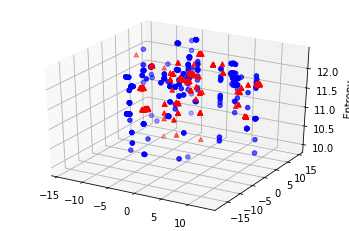

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 367 samples in 0.003s...
[t-SNE] Computed neighbors for 367 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 367 / 367
[t-SNE] Mean sigma: 0.025096
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.127705
[t-SNE] KL divergence after 300 iterations: 0.064372
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 367 samples in 0.002s...
[t-SNE] Computed neighbors for 367 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 367 / 367
[t-SNE] Mean sigma: 0.029321
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.584240
[t-SNE] KL divergence after 300 iterations: 0.073583


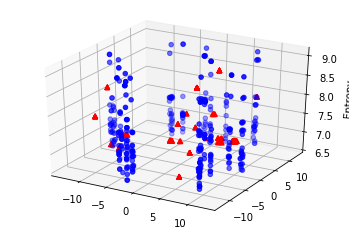

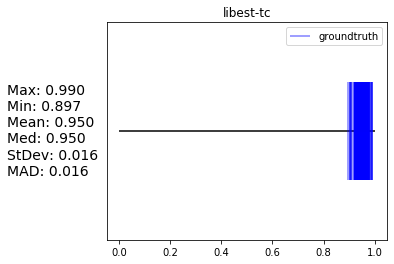

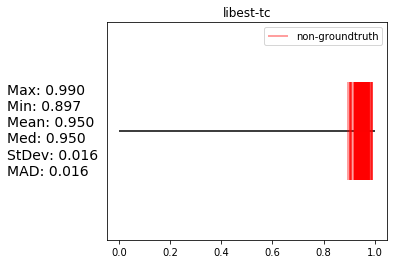

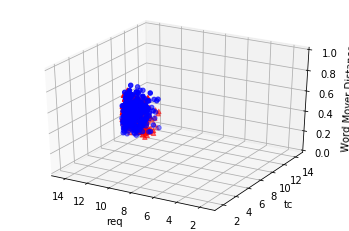

In [ ]:
entropy_trace_req2tc_benchmark.visualize()

In [ ]:
new_model = gensim.models.Word2Vec.load("/tf/main/nbs/test_data/models/word2vec_libest.model")
new_model.init_sims(replace=True)

04/29/2020 16:59:24 - INFO - gensim.utils -   loading Word2Vec object from /tf/main/nbs/test_data/models/word2vec_libest.model
04/29/2020 16:59:24 - INFO - gensim.utils -   loading wv recursively from /tf/main/nbs/test_data/models/word2vec_libest.model.wv.* with mmap=None
04/29/2020 16:59:24 - INFO - gensim.utils -   setting ignored attribute vectors_norm to None
04/29/2020 16:59:24 - INFO - gensim.utils -   loading vocabulary recursively from /tf/main/nbs/test_data/models/word2vec_libest.model.vocabulary.* with mmap=None
04/29/2020 16:59:24 - INFO - gensim.utils -   loading trainables recursively from /tf/main/nbs/test_data/models/word2vec_libest.model.trainables.* with mmap=None
04/29/2020 16:59:24 - INFO - gensim.utils -   setting ignored attribute cum_table to None
04/29/2020 16:59:24 - INFO - gensim.utils -   loaded /tf/main/nbs/test_data/models/word2vec_libest.model
04/29/2020 16:59:24 - INFO - gensim.models.keyedvectors -   precomputing L2-norms of word weight vectors


In [ ]:
np.sum(model.wv['requir'])

0.0481819

In [ ]:
model.wv['requir']

array([ 5.15010543e-02, -9.79734585e-02, -2.62769014e-01, -1.13625992e-02,
        1.85345244e-02,  8.97615999e-02,  2.70228028e-01,  3.19023505e-02,
       -1.07832402e-02, -1.14436708e-01, -9.42954794e-02, -3.12492065e-02,
       -2.81266943e-02,  7.21591860e-02, -9.56829935e-02,  7.68008009e-02,
        1.24175185e-02,  7.96231553e-02,  9.92943794e-02,  7.55291283e-02,
        5.19860350e-02,  6.08928464e-02, -1.46261724e-02,  7.73183033e-02,
        2.33692631e-01,  2.06158936e-01, -6.25407649e-03,  1.67590946e-01,
       -4.43011820e-02,  6.95720166e-02, -2.77503207e-02, -6.93461522e-02,
        9.77298827e-04, -1.11260630e-01,  1.27182484e-01, -3.59623693e-02,
        8.20966586e-02,  1.31493941e-01, -2.61976477e-02, -1.01758435e-01,
        1.87294539e-02, -5.81729300e-02, -1.81808509e-02, -9.08695236e-02,
        5.06898277e-02,  1.04065299e-01,  1.08785369e-01, -6.48387820e-02,
        1.12542152e-01, -2.00890943e-01, -7.08937496e-02, -8.16279501e-02,
       -8.95328075e-02,  

## Add note about why use mean instead of sum

In [ ]:
src_vecs, trgt_vecs = [], []
for src_doc, trgt_doc in zip(req2src.src_doc.values, req2src.trgt_doc.values):
    src_vec = np.asarray([model.wv[key] for key in src_doc.split()])
    src_vec = np.mean(src_vec, axis = 0)
    trgt_vec = np.asarray([model.wv[key] for key in trgt_doc.split()])
    trgt_vec = np.mean(trgt_vec, axis = 0)
    
    src_vecs.append(src_vec)
    trgt_vecs.append(trgt_vec)

In [ ]:
req2src['src_vec'] = src_vecs
req2src['trgt_vec'] = trgt_vecs

In [ ]:
new_req2src = req2src[['src_dtype', 'trgt_dtype', 'src_file', 'trgt_file', 'src_doc', 'trgt_doc', 'src_vec', 'trgt_vec', 'wmd', 'ground_truth']]

,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,wmd,ground_truth,src_vec,trgt_vec
0,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est.h,requir server key generat follow exampl valid ...,file est est public api enrol secur transport ...,0.340562,0,"[0.0031412598, -0.11988081, -0.28746873, 0.011...","[-0.019092537, -0.12634756, -0.2693117, 0.0107..."
1,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir certif less tls mutual authent certif l...,static pthread pthread self void return get cu...,0.410977,0,"[0.035024192, -0.11070093, -0.26910967, 0.0077...","[-0.016639384, -0.12135821, -0.279722, 0.00970..."
2,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir client use implicit databas est client ...,prototyp privat est server part public api voi...,0.386474,0,"[0.029802034, -0.11710332, -0.26550922, 0.0048...","[-0.034480657, -0.14800207, -0.26153752, 0.018..."
3,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir inform refer idev ieee standard associ ...,libest test api void est log est log level lvl...,0.447825,0,"[0.013193383, -0.115334034, -0.2819848, 0.0099...","[-0.042793117, -0.12860508, -0.2682275, 0.0065..."
4,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir tls client authent recommend method ide...,tcw err tcw connect tcw sock sock tcw opt opt ...,0.532702,0,"[0.035600312, -0.11806617, -0.2603899, 0.00890...","[-0.025590535, -0.114425845, -0.285615, 0.0058..."


In [ ]:
new_req2src = req2src[['src_dtype', 'trgt_dtype', 'src_file', 'trgt_file', 'src_doc', 'trgt_doc', 'src_vec', 'trgt_vec', 'wmd', 'ground_truth']]
new_req2src.head()

,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,src_vec,trgt_vec,wmd,ground_truth
0,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est.h,requir server key generat follow exampl valid ...,file est est public api enrol secur transport ...,"[0.0031412598, -0.11988081, -0.28746873, 0.011...","[-0.019092537, -0.12634756, -0.2693117, 0.0107...",0.340562,0
1,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir certif less tls mutual authent certif l...,static pthread pthread self void return get cu...,"[0.035024192, -0.11070093, -0.26910967, 0.0077...","[-0.016639384, -0.12135821, -0.279722, 0.00970...",0.410977,0
2,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir client use implicit databas est client ...,prototyp privat est server part public api voi...,"[0.029802034, -0.11710332, -0.26550922, 0.0048...","[-0.034480657, -0.14800207, -0.26153752, 0.018...",0.386474,0
3,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir inform refer idev ieee standard associ ...,libest test api void est log est log level lvl...,"[0.013193383, -0.115334034, -0.2819848, 0.0099...","[-0.042793117, -0.12860508, -0.2682275, 0.0065...",0.447825,0
4,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir tls client authent recommend method ide...,tcw err tcw connect tcw sock sock tcw opt opt ...,"[0.035600312, -0.11806617, -0.2603899, 0.00890...","[-0.025590535, -0.114425845, -0.285615, 0.0058...",0.532702,0


In [ ]:
req2src.columns, new_req2src.columns

(Index(['src_dtype', 'trgt_dtype', 'src_file', 'trgt_file', 'src_doc',
        'trgt_doc', 'wmd', 'ground_truth', 'src_vec', 'trgt_vec'],
       dtype='object'),
 Index(['src_dtype', 'trgt_dtype', 'src_file', 'trgt_file', 'src_doc',
        'trgt_doc', 'src_vec', 'trgt_vec', 'wmd', 'ground_truth'],
       dtype='object'))

In [ ]:
new_req2src.to_csv('/tf/main/benchmarking/traceability/testbeds/nltk/libest_req2src.csv', index=False)

In [ ]:
new_req2src.iloc[0]['src_vec']

array([ 0.00314126, -0.11988081, -0.28746873,  0.01172288,  0.06187648,
        0.10759547,  0.23292126,  0.08737477, -0.02719483, -0.11510732,
       -0.04803624, -0.04844419, -0.012379  ,  0.10769729, -0.08871354,
       -0.00591579, -0.02452177,  0.1129517 ,  0.0857418 ,  0.00892831,
       -0.01900305,  0.07727785,  0.01524534,  0.10777587,  0.22458094,
        0.18147703,  0.03898545,  0.12245347, -0.05185317,  0.04040194,
        0.05956536, -0.07907865, -0.05457791, -0.1744715 ,  0.16564552,
       -0.01130053,  0.01941668,  0.09401554, -0.0581401 , -0.11260852,
       -0.041188  , -0.11491706, -0.04600274,  0.00391768,  0.0498553 ,
        0.12522225,  0.08951521, -0.03868822,  0.09894913, -0.18486825,
       -0.01759241, -0.09799492, -0.0365665 ,  0.11935702, -0.05368097,
       -0.04078052, -0.05348172, -0.02276937,  0.1685632 , -0.15495078,
       -0.0279893 , -0.01774516,  0.23565453,  0.15086497,  0.0155919 ,
       -0.03131004, -0.19996023,  0.04308473,  0.06074061, -0.03

In [ ]:
src_vecs, trgt_vecs = [], []
for src_doc, trgt_doc in zip(req2tc.src_doc.values, req2tc.trgt_doc.values):
    src_vec = np.asarray([model.wv[key] for key in src_doc.split()])
    src_vec = np.mean(src_vec, axis = 0)
    trgt_vec = np.asarray([model.wv[key] for key in trgt_doc.split()])
    trgt_vec = np.mean(trgt_vec, axis = 0)
    
    src_vecs.append(src_vec)
    trgt_vecs.append(trgt_vec)

In [ ]:
req2tc['src_vec'] = src_vecs
req2tc['trgt_vec'] = trgt_vecs

In [ ]:
new_req2tc = req2tc[['src_dtype', 'trgt_dtype', 'src_file', 'trgt_file', 'src_doc', 'trgt_doc', 'src_vec', 'trgt_vec', 'wmd', 'ground_truth']]
new_req2tc.head()

,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,src_vec,trgt_vec,wmd,ground_truth
0,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,requir full pki request messag full pki reques...,unit test uri path segment extens support marc...,"[0.030355334, -0.113834456, -0.26580575, 0.004...","[-0.03977351, -0.14905816, -0.25422758, 0.0321...",0.533299,0
1,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1005.c,requir terminolog key word must must requir sh...,unit test user stori client easi provis novemb...,"[0.020765, -0.1239785, -0.2671596, 0.013038781...","[-0.011349318, -0.12563385, -0.2688628, 0.0123...",0.334297,0
2,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,requir request asymmetr encrypt privat key spe...,unit test user stori tls srp support server pr...,"[-0.019037372, -0.15851521, -0.2653666, 0.0342...","[-0.004516872, -0.11426209, -0.27722117, 0.009...",0.304404,0
3,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us895.c,requir tls client authent recommend method ide...,unit test user stori proxi csr attribut novemb...,"[0.035600312, -0.11806617, -0.2603899, 0.00890...","[-0.00619808, -0.09637509, -0.24735866, 0.0112...",0.618677,1
4,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,requir iana consider section defin oid regist ...,unit test user stori tls srp support server pr...,"[0.014550774, -0.11760523, -0.27798823, 0.0093...","[-0.004516872, -0.11426209, -0.27722117, 0.009...",0.234525,0


In [ ]:
new_req2tc.to_csv('/tf/main/benchmarking/traceability/testbeds/nltk/libest_req2tc.csv', index=False)

In [ ]:
links_df = get_gt_links(path/'groundtruth/english', 'english')
links_df = links_df.loc[links_df['sys'] == 'libest'].copy()
links_df.head()

,sys,src_type,trgt_type,src_file,trgt_file
0,libest,req,src,RQ18.txt,est_server.c
1,libest,req,src,RQ57.txt,est_client_http.c
2,libest,req,src,RQ29.txt,est_locl.h
3,libest,req,src,RQ21.txt,est_client.c
4,libest,req,src,RQ8.txt,est_locl.h


In [ ]:
len(links_df)

539

In [ ]:
len(req2src)

100

In [ ]:
req2src['ground_truth'] = [0] * len(req2src)

In [ ]:
for i in range(len(req2src)):
    src_file = str(Path(req2src.iloc[i].src_file).name).replace('-pre', '')
    trgt_file = str(Path(req2src.iloc[i].trgt_file).name).replace('-pre', '')
    for j in range(len(links_df)):
        if str(links_df.iloc[j].src_file) == src_file:
            if str(links_df.iloc[j].trgt_file) == trgt_file:
                req2src.at[i, 'ground_truth'] = 1

In [ ]:
len(req2src.loc[req2src.ground_truth == 1]), len(req2src.loc[req2src.ground_truth == 0])

(30, 70)

In [ ]:
req2src.to_csv('/tf/main/benchmarking/traceability/testbeds/nltk/libest_req2src.csv', index=False)

In [ ]:
libest_req2tc.csv

In [ ]:
req2tc = pd.read_csv(path/'nltk/libest_req2tc.csv')
req2tc.head()

,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,wmd
0,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,requir full pki request messag full pki reques...,unit test uri path segment extens support marc...,0.533299
1,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1005.c,requir terminolog key word must must requir sh...,unit test user stori client easi provis novemb...,0.334297
2,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,requir request asymmetr encrypt privat key spe...,unit test user stori tls srp support server pr...,0.304404
3,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us895.c,requir tls client authent recommend method ide...,unit test user stori proxi csr attribut novemb...,0.618677
4,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,requir iana consider section defin oid regist ...,unit test user stori tls srp support server pr...,0.234525


In [ ]:
req2tc['ground_truth'] = [0] * len(req2tc)

In [ ]:
for i in range(len(req2tc)):
    src_file = str(Path(req2tc.iloc[i].src_file).name).replace('-pre', '')
    trgt_file = str(Path(req2tc.iloc[i].trgt_file).name).replace('-pre', '')
    for j in range(len(links_df)):
        if str(links_df.iloc[j].src_file) == src_file:
            if str(links_df.iloc[j].trgt_file) == trgt_file:
                req2tc.at[i, 'ground_truth'] = 1

In [ ]:
len(req2tc.loc[req2tc.ground_truth == 1]), len(req2tc.loc[req2tc.ground_truth == 0])

(367, 825)

In [ ]:
req2tc.to_csv('/tf/main/benchmarking/traceability/testbeds/nltk/libest_req2tc.csv', index=False)

In [ ]:
libest_req2src_tstbd = TraceabilityEntropyTestbed(req2src.src_docs, req2src.trgt_docs, req2src.wmd)

In [ ]:
path = Path('test_data'); list(path.glob('*'))

[PosixPath('test_data/LibEST_semeru_format'),
 PosixPath('test_data/java_tokenizer-vocab.json'),
 PosixPath('test_data/[libest-req2src-wmd].csv'),
 PosixPath('test_data/models'),
 PosixPath('test_data/[libest-sim-wmd].csv'),
 PosixPath('test_data/.ipynb_checkpoints'),
 PosixPath('test_data/text.txt'),
 PosixPath('test_data/tst.csv'),
 PosixPath('test_data/[libest-req2tc-wmd-1587779231.06381].csv'),
 PosixPath('test_data/config_corpus'),
 PosixPath('test_data/trn.csv'),
 PosixPath('test_data/[libest-req2tc-wmd].csv'),
 PosixPath('test_data/requirements.csv'),
 PosixPath('test_data/java_tokenizer-merges.txt'),
 PosixPath('test_data/val.csv')]

In [ ]:
req2src_wmd_df = pd.read_csv(
    path/'[libest-req2src-wmd].csv',
    header = None, names = ['src_file', 'trgt_file', 'wmd'],
    delimiter = ' '
)
# req2src_wmd_df['src_file'] = req2src_wmd_df['src_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2src_wmd_df['src_dtype'] = ['req'] * len(req2src_wmd_df)
# req2src_wmd_df['trgt_file'] = req2src_wmd_df['trgt_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2src_wmd_df['trgt_dtype'] = ['src'] * len(req2src_wmd_df)

In [ ]:
path = Path('../benchmarking/traceability/testbeds'); list(path.glob('*'))
sys = 'libest'
req_df = pd.read_csv(path/f'nltk/[{sys}-pre-req].csv', header = None, names = ['file', 'text'], delimiter = ' ')
src_df = pd.read_csv(path/f'nltk/[{sys}-pre-src].csv', header = None, names = ['file', 'text'], delimiter = ' ')
tc_df = pd.read_csv(path/f'nltk/[{sys}-pre-tc].csv', header = None, names = ['file', 'text'], delimiter = ' ')
# Concat df into a single df of the system
nltk_df = pd.concat([req_df, src_df, tc_df]).reset_index(drop = True)
# nltk_df['file'] = nltk_df['file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
nltk_df.head()

,file,text
0,test_data/LibEST_semeru_format/requirements/RQ...,requir http uri control est server must suppor...
1,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat respons request...
2,test_data/LibEST_semeru_format/requirements/RQ...,requir http base client authent est server may...
3,test_data/LibEST_semeru_format/requirements/RQ...,requir csr attribut request est client request...
4,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat est client may ...


In [ ]:
src_docs, trgt_docs = get_nltk_docs(nltk_df, req2src_wmd_df.src_file.values, req2src_wmd_df.trgt_file.values)

In [ ]:
req2src_wmd_df['src_doc'] = src_docs
req2src_wmd_df['trgt_doc'] = trgt_docs
req2src_wmd_df.head()

,src_file,trgt_file,wmd,src_dtype,trgt_dtype,src_doc,trgt_doc
0,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est.h,0.340562,req,src,requir server key generat follow exampl valid ...,file est est public api enrol secur transport ...
1,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,0.410977,req,src,requir certif less tls mutual authent certif l...,static pthread pthread self void return get cu...
2,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,0.386474,req,src,requir client use implicit databas est client ...,prototyp privat est server part public api voi...
3,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,0.447825,req,src,requir inform refer idev ieee standard associ ...,libest test api void est log est log level lvl...
4,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,0.532702,req,src,requir tls client authent recommend method ide...,tcw err tcw connect tcw sock sock tcw opt opt ...


In [ ]:
nltk_req2src_df = req2src_wmd_df[['src_dtype', 'trgt_dtype','src_file', 'trgt_file', 'src_doc', 'trgt_doc', 'wmd']]
nltk_req2src_df.head()

,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,wmd
0,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est.h,requir server key generat follow exampl valid ...,file est est public api enrol secur transport ...,0.340562
1,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir certif less tls mutual authent certif l...,static pthread pthread self void return get cu...,0.410977
2,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir client use implicit databas est client ...,prototyp privat est server part public api voi...,0.386474
3,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir inform refer idev ieee standard associ ...,libest test api void est log est log level lvl...,0.447825
4,req,src,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,requir tls client authent recommend method ide...,tcw err tcw connect tcw sock sock tcw opt opt ...,0.532702


In [ ]:
nltk_req2src_df.to_csv('/tf/main/benchmarking/traceability/testbeds/nltk/libest_req2src.csv', index=False)

In [ ]:
path = Path('test_data'); list(path.glob('*'))

[PosixPath('test_data/LibEST_semeru_format'),
 PosixPath('test_data/java_tokenizer-vocab.json'),
 PosixPath('test_data/[libest-req2src-wmd].csv'),
 PosixPath('test_data/models'),
 PosixPath('test_data/[libest-sim-wmd].csv'),
 PosixPath('test_data/.ipynb_checkpoints'),
 PosixPath('test_data/text.txt'),
 PosixPath('test_data/tst.csv'),
 PosixPath('test_data/[libest-req2tc-wmd-1587779231.06381].csv'),
 PosixPath('test_data/config_corpus'),
 PosixPath('test_data/trn.csv'),
 PosixPath('test_data/[libest-req2tc-wmd].csv'),
 PosixPath('test_data/requirements.csv'),
 PosixPath('test_data/java_tokenizer-merges.txt'),
 PosixPath('test_data/val.csv')]

In [ ]:
req2tc_wmd_df = pd.read_csv(
    path/'[libest-req2tc-wmd].csv',
    header = None, names = ['src_file', 'trgt_file', 'wmd'],
    delimiter = ' '
)
# req2tc_wmd_df['src_file'] = req2tc_wmd_df['src_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2tc_wmd_df['src_dtype'] = ['req'] * len(req2tc_wmd_df)
# req2tc_wmd_df['trgt_file'] = req2tc_wmd_df['trgt_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2tc_wmd_df['trgt_dtype'] = ['tc'] * len(req2tc_wmd_df)

In [ ]:
src_docs, trgt_docs = get_nltk_docs(nltk_df, req2tc_wmd_df.src_file.values, req2tc_wmd_df.trgt_file.values)

In [ ]:
req2tc_wmd_df['src_doc'] = src_docs
req2tc_wmd_df['trgt_doc'] = trgt_docs
req2tc_wmd_df.head()

,src_file,trgt_file,wmd,src_dtype,trgt_dtype,src_doc,trgt_doc
0,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,0.533299,req,tc,requir full pki request messag full pki reques...,unit test uri path segment extens support marc...
1,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1005.c,0.334297,req,tc,requir terminolog key word must must requir sh...,unit test user stori client easi provis novemb...
2,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,0.304404,req,tc,requir request asymmetr encrypt privat key spe...,unit test user stori tls srp support server pr...
3,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us895.c,0.618677,req,tc,requir tls client authent recommend method ide...,unit test user stori proxi csr attribut novemb...
4,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,0.234525,req,tc,requir iana consider section defin oid regist ...,unit test user stori tls srp support server pr...


In [ ]:
nltk_req2tc_df = req2tc_wmd_df[['src_dtype', 'trgt_dtype','src_file', 'trgt_file', 'src_doc', 'trgt_doc', 'wmd']]
nltk_req2tc_df.head()

,src_dtype,trgt_dtype,src_file,trgt_file,src_doc,trgt_doc,wmd
0,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,requir full pki request messag full pki reques...,unit test uri path segment extens support marc...,0.533299
1,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1005.c,requir terminolog key word must must requir sh...,unit test user stori client easi provis novemb...,0.334297
2,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,requir request asymmetr encrypt privat key spe...,unit test user stori tls srp support server pr...,0.304404
3,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us895.c,requir tls client authent recommend method ide...,unit test user stori proxi csr attribut novemb...,0.618677
4,req,tc,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us1060.c,requir iana consider section defin oid regist ...,unit test user stori tls srp support server pr...,0.234525


In [ ]:
nltk_req2tc_df.to_csv('/tf/main/benchmarking/traceability/testbeds/nltk/libest_req2tc.csv', index=False)

In [ ]:
req2src_wmd_df = pd.read_csv(
    path/'[libest-req2src-wmd].csv',
    header = None, names = ['src_file', 'trgt_file', 'wmd'],
    delimiter = ' '
)
# req2src_wmd_df['src_file'] = req2src_wmd_df['src_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2src_wmd_df['src_dtype'] = ['req'] * len(req2src_wmd_df)
# req2src_wmd_df['trgt_file'] = req2src_wmd_df['trgt_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2src_wmd_df['trgt_dtype'] = ['src'] * len(req2src_wmd_df)

req2tc_wmd_df = pd.read_csv(
    path/'[libest-req2tc-wmd].csv',
    header = None, names = ['src_file', 'trgt_file', 'wmd'],
    delimiter = ' '
)
# req2tc_wmd_df['src_file'] = req2tc_wmd_df['src_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2tc_wmd_df['src_dtype'] = ['req'] * len(req2tc_wmd_df)
# req2tc_wmd_df['trgt_file'] = req2tc_wmd_df['trgt_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2tc_wmd_df['trgt_dtype'] = ['tc'] * len(req2tc_wmd_df)

In [ ]:
req2src_wmd_df.head()

,src_file,trgt_file,wmd,src_dtype,trgt_dtype
0,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est.h,0.340562,req,src
1,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,0.410977,req,src
2,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,0.386474,req,src
3,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,0.447825,req,src
4,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/source_code/est...,0.532702,req,src


In [ ]:
sys = 'libest'
path = Path('../benchmarking/traceability/testbeds')
req_df = pd.read_csv(path/f'nltk/[{sys}-pre-req].csv', header = None, names = ['file', 'text'], delimiter = ' ')
src_df = pd.read_csv(path/f'nltk/[{sys}-pre-src].csv', header = None, names = ['file', 'text'], delimiter = ' ')
tc_df = pd.read_csv(path/f'nltk/[{sys}-pre-tc].csv', header = None, names = ['file', 'text'], delimiter = ' ')

In [ ]:
req_df.head()

,file,text
0,test_data/LibEST_semeru_format/requirements/RQ...,requir http uri control est server must suppor...
1,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat respons request...
2,test_data/LibEST_semeru_format/requirements/RQ...,requir http base client authent est server may...
3,test_data/LibEST_semeru_format/requirements/RQ...,requir csr attribut request est client request...
4,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat est client may ...


In [ ]:
srcs = req2src_wmd_df[['src_file', 'src_dtype']]
trgts = req2src_wmd_df[['trgt_file', 'trgt_dtype']]

nltk_gt_tstbed_req2src = TraceabilityTestbed(srcs.src_file, trgts.trgt_file, req2src_wmd_df.wmd)
nltk_gt_tstbed_req2src[:10]

[('RQ58.txt', 'est.h', 0.3405619296743265),
 ('RQ23.txt', 'est_server_http.c', 0.4109769453867617),
 ('RQ28.txt', 'est_server.h', 0.3864743377880668),
 ('RQ53.txt', 'est_locl.h', 0.4478248733612722),
 ('RQ22.txt', 'est_client_proxy.h', 0.5327022985764046),
 ('RQ18.txt', 'est_ossl_util.c', 0.4590752244511882),
 ('RQ38.txt', 'est_server.c', 0.33263853577238883),
 ('RQ41.txt', 'est_client_http.c', 0.3541091821678013),
 ('RQ17.txt', 'est_locl.h', 0.4844593223621954),
 ('RQ47.txt', 'est.h', 0.38554294144939055)]

In [ ]:
req_df = pd.read_csv(path/f'nltk/[{sys}-pre-req].csv', header = None, names = ['file', 'text'], delimiter = ' ')
src_df = pd.read_csv(path/f'nltk/[{sys}-pre-src].csv', header = None, names = ['file', 'text'], delimiter = ' ')
tc_df = pd.read_csv(path/f'nltk/[{sys}-pre-tc].csv', header = None, names = ['file', 'text'], delimiter = ' ')

In [ ]:
path = Path('../benchmarking/traceability/')

# SCRATCH CODE

In [ ]:
english_bpe = 'english_bpe'
italian_bpe = 'italian_bpe'

In [ ]:
libest_bpe = 'libest_only_bpe'
sp_model_from_glob(path/'datasets/english/libest','*all*', libest_bpe)

In [ ]:
sp_model_from_glob(path/'datasets/english','*/*all*', english_bpe)
sp_model_from_glob(path/'datasets/italian','*/*all*', italian_bpe)

In [ ]:
path/'datasets'

PosixPath('../benchmarking/traceability/datasets')

In [ ]:
def output_bpe_tokenization(path, languages):
    for language in languages:
        req_fns = list((path/'datasets'/language).glob('**/*req]'))
        src_fns = list((path/'datasets'/language).glob('**/*src]'))
        tc_fns = list((path/'datasets'/language).glob('**/*tc]'))

        spm = sp.SentencePieceProcessor()
        spm.Load(str((path/'datasets'/language/f"{language}_bpe.model")))
        
        output = path/'testbeds'/'bpe'/language
        req_docs = tokenize_fns(req_fns, spm, ['txt', 'TXT'], output, 'req')
        src_docs = tokenize_fns(src_fns, spm, ['c', 'h', 'java', 'jsp'], output, 'src')
        tc_docs = tokenize_fns(tc_fns, spm, ['c', 'h', 'java', 'jsp'], output, 'tc')

In [ ]:
languages = ['english', 'italian']
output_bpe_tokenization(path, languages)

In [ ]:
def output_sys_bpe_tokenization(path, language, sys, bpe_model):
    req_fns = list((path/'datasets'/language/sys).glob('**/*req]'))
    src_fns = list((path/'datasets'/language/sys).glob('**/*src]'))
    tc_fns = list((path/'datasets'/language/sys).glob('**/*tc]'))

    spm = sp.SentencePieceProcessor()
    spm.Load(str((path/'datasets'/language/sys/f"{bpe_model}.model")))

    output = path/'testbeds'/'bpe'/language
    req_docs = tokenize_fns(req_fns, spm, ['txt', 'TXT'], output, 'req')
    src_docs = tokenize_fns(src_fns, spm, ['c', 'h', 'java', 'jsp'], output, 'src')
    tc_docs = tokenize_fns(tc_fns, spm, ['c', 'h', 'java', 'jsp'], output, 'tc')
    
    vocab = {spm.id_to_piece(id): 0 for id in range(spm.get_piece_size())}
    return vocab

In [ ]:
vocab = output_sys_bpe_tokenization(path, 'english', 'libest', libest_bpe)

# Entropy Benchmark

In [ ]:
def benchmark_testbed(gt, ngt, sys, data_type):
    gt = gt.loc[gt['sys'] == sys]
    ngt = ngt.loc[ngt['sys'] == sys]
    gt = gt.loc[gt['to_type'] == data_type]
    ngt = ngt.loc[ngt['to_type'] == data_type]
    
    gt_from = gt['from_doc'].sample(frac = 1).to_list()[:100]
    gt_to = gt['to_doc'].sample(frac = 1).to_list()[:100]
    gt_to_files = gt['to_file'].sample(frac = 1).to_list()[:100]
    gt_to_cnt = Counter()
    for file in gt_to_files:
        gt_to_cnt[file] += 1
    ngt_from = ngt['from_doc'].sample(frac = 1).to_list()[:100]
    ngt_to = ngt['to_doc'].sample(frac = 1).to_list()[:100]
    
    return gt_from, gt_to, gt_to_cnt, ngt_from, ngt_to

In [ ]:
def benchmark_metrics(from_docs, to_docs, vocab):
    from_entropies = get_entropies_from_docs(from_docs, vocab)
    to_entropies = get_entropies_from_docs(to_docs, vocab)

    shared_probs = [get_shared_probs_from_docs([[docs[0]], [docs[1]]], vocab)[0] for docs in zip(from_docs, to_docs)]
    
    return from_entropies, to_entropies, shared_probs

In [ ]:
def benchmark_visualize(gts, ngts, gt_to_cnt, sys, trgt_type):
    visualize_gt_ngt([gts[0], gts[1]], [ngts[0], ngts[1]], sys, trgt_type)
    visualize_events(gts[2], 'b', f'{sys}-{trgt_type}', 'groundtruth')
    visualize_events(ngts[2], 'r', f'{sys}-{trgt_type}', 'non-groundtruth')
    plot_counts(gt_to_cnt, 'File', 'Entropy', top_k = 5)

In [ ]:
def entropy_vis_gt_ngt(gt_entropies, ngt_entropies, sys, trgt_dtype):
    visualize_gt_ngt([gt_entropies[0], gt_entropies[1]], [ngt_entropies[0], ngt_entropies[1]], sys, trgt_dtype)

In [ ]:
def entropy_metrics(gt, ngt, vocab):
    src_dtypes = gt.src_type.unique()
    src_docs = [(dtype, gt.loc[gt.src_type == dtype].src_doc.values)for dtype in src_dtypes]
    for dtype, docs in src_docs:
        e = get_entropies_from_docs(docs, vocab)
        print(f'Source Datatype: {dtype}')
        report_stats(e)
        print()
    
    trgt_dtypes = gt.trgt_type.unique()
    trgt_docs = [(dtype, gt.loc[gt.trgt_type == dtype].trgt_doc.values) for dtype in trgt_dtypes]
    for dtype, docs in trgt_docs:
        e = get_entropies_from_docs(docs, vocab)
        print(f'Target Datatype: {dtype}')
        report_stats(e)
        print()
        
    all_docs = [docs for _, docs in src_docs + trgt_docs]
    entropy = get_entropy_from_docs(flatten(all_docs), vocab)
    print(f'Total System Entropy:', entropy)
    entropy = shared_entropy_from_docs(all_docs, vocab)
    print('Shared Entropy:', entropy)
    shared_prob, shared_info_content = get_shared_probs_from_docs(all_docs, vocab)
    print('Shared Relative Probability:', shared_prob)

In [ ]:
def entropy_visualize(gt, ngt, vocab):
    src_dtypes = gt.src_type.unique()
    trgt_dtypes = gt.trgt_type.unique()
    for src_dtype in src_dtypes:
        for trgt_dtype in trgt_dtypes:
            gt_docs_src = gt.loc[gt.src_type == src_dtype].loc[gt.trgt_type == trgt_dtype].src_doc.values
            gt_docs_trgt = gt.loc[gt.src_type == src_dtype].loc[gt.trgt_type == trgt_dtype].trgt_doc.values
            gt_src_entropies = get_entropies_from_docs(gt_docs_src, vocab)[:15]
            gt_trgt_entropies = get_entropies_from_docs(gt_docs_trgt, vocab)[:15]
            gt_shared_probs = [get_shared_probs_from_docs([[docs[0]], [docs[1]]], vocab)[0] for docs in zip(gt_docs_src, gt_docs_trgt)]
            gt_wmds = gt.loc[gt.src_type == 'req'].loc[gt.trgt_type == 'src'].wmd.values[:15]

            ngt_docs_src = ngt.loc[ngt.src_type == src_dtype].loc[ngt.trgt_type == trgt_dtype].src_doc.values
            ngt_docs_trgt = ngt.loc[ngt.src_type == src_dtype].loc[ngt.trgt_type == trgt_dtype].trgt_doc.values
            ngt_src_entropies = get_entropies_from_docs(ngt_docs_src, vocab)[:15]
            ngt_trgt_entropies = get_entropies_from_docs(ngt_docs_trgt, vocab)[:15]
            ngt_shared_probs = [get_shared_probs_from_docs([[docs[0]], [docs[1]]], vocab)[0] for docs in zip(ngt_docs_src, ngt_docs_trgt)]
            ngt_wmds = ngt.loc[ngt.src_type == 'req'].loc[ngt.trgt_type == 'src'].wmd.values[:15]
            visualize_events(gt_shared_probs, 'b', f'libest-{trgt_dtype}', 'groundtruth')
            visualize_events(ngt_shared_probs, 'r', f'libest-{trgt_dtype}', 'non-groundtruth')
            vis_3d(
                [gt_src_entropies, gt_trgt_entropies, gt_wmds],
                [ngt_src_entropies, ngt_trgt_entropies, ngt_wmds],
                src_dtype, trgt_dtype
            )

In [ ]:
def calc_entropy_benchmark(path, systems, lang, vocab):
    gt, ngt = gen_gt_ngt(path/'testbeds', lang)
    for sys in systems:
        print('System:', sys)
        
        sys_docs = []
        for data_type in systems[sys]:
            if data_type != 'req':
                gt_from, gt_to, gt_to_cnt, ngt_from, ngt_to = benchmark_testbed(gt, ngt, sys, data_type)
                gt_from_entropies, gt_to_entropies, gt_shared_probs = benchmark_metrics(gt_from, gt_to, vocab)
                ngt_from_entropies, ngt_to_entropies, ngt_shared_probs = benchmark_metrics(ngt_from, ngt_to, vocab)
                benchmark_visualize([gt_from_entropies, gt_to_entropies, gt_shared_probs],
                                    [ngt_from_entropies, ngt_to_entropies, ngt_shared_probs],
                                    gt_to_cnt, sys, data_type
                                   )
            
            data_path = path/'testbeds/bpe'/lang/sys/data_type
            sys_docs.append(read_bpe_files(data_path))
            entropies = get_entropies_from_docs(sys_docs[-1], vocab)

            print('Data Type:', data_type)
            report_stats(entropies)

            entropy = get_entropy_from_docs(sys_docs[-1], vocab)
            print('Total Corpus Entropy:', entropy)
            print()

        entropy = get_entropy_from_docs(flatten(sys_docs), vocab)
        print('Total System Entropy:', entropy)
        entropy = shared_entropy_from_docs(sys_docs, vocab)
        print('Shared Entropy:', entropy)
        shared_prob, shared_info_content = get_shared_probs_from_docs(sys_docs, vocab)
        print('Shared Relative Probability:', shared_prob)
#         print('Shared Information Content:', shared_info_content)
        print()

## NLTK Entropy Analysis

In [ ]:
path = Path('test_data'); list(path.glob('*'))

[PosixPath('test_data/LibEST_semeru_format'),
 PosixPath('test_data/java_tokenizer-vocab.json'),
 PosixPath('test_data/[libest-req2src-wmd].csv'),
 PosixPath('test_data/test.model'),
 PosixPath('test_data/[libest-sim-wmd].csv'),
 PosixPath('test_data/.ipynb_checkpoints'),
 PosixPath('test_data/test.vocab'),
 PosixPath('test_data/text.txt'),
 PosixPath('test_data/tst.csv'),
 PosixPath('test_data/config_corpus'),
 PosixPath('test_data/trn.csv'),
 PosixPath('test_data/[libest-req2tc-wmd].csv'),
 PosixPath('test_data/java_tokenizer-merges.txt'),
 PosixPath('test_data/val.csv')]

In [ ]:
req2src_wmd_df = pd.read_csv(
    path/'[libest-req2src-wmd].csv',
    header = None, names = ['src_file', 'trgt_file', 'wmd'],
    delimiter = ' '
)
req2src_wmd_df['src_file'] = req2src_wmd_df['src_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2src_wmd_df['trgt_file'] = req2src_wmd_df['trgt_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2src_wmd_df['trgt_dtype'] = ['src'] * len(req2src_wmd_df)
req2src_wmd_df.head()

,src_file,trgt_file,wmd,trgt_dtype
0,RQ58.txt,est.h,0.340562,src
1,RQ23.txt,est_server_http.c,0.410977,src
2,RQ28.txt,est_server.h,0.386474,src
3,RQ53.txt,est_locl.h,0.447825,src
4,RQ22.txt,est_client_proxy.h,0.532702,src


In [ ]:
req2tc_wmd_df = pd.read_csv(
    path/'[libest-req2tc-wmd].csv',
    header = None, names = ['src_file', 'trgt_file', 'wmd'],
    delimiter = ' '
)
req2tc_wmd_df['src_file'] = req2tc_wmd_df['src_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2tc_wmd_df['trgt_file'] = req2tc_wmd_df['trgt_file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
req2tc_wmd_df['trgt_dtype'] = ['tc'] * len(req2tc_wmd_df)
req2tc_wmd_df.head()

,src_file,trgt_file,wmd,trgt_dtype
0,RQ11.txt,us3496.c,0.533299,tc
1,RQ2.txt,us1005.c,0.334297,tc
2,RQ45.txt,us1060.c,0.304404,tc
3,RQ22.txt,us895.c,0.618677,tc
4,RQ50.txt,us1060.c,0.234525,tc


In [ ]:
wmd_df = pd.concat([req2src_wmd_df, req2tc_wmd_df]).reset_index(drop = True)
wmd_df.head()

,src_file,trgt_file,wmd,trgt_dtype
0,RQ58.txt,est.h,0.340562,src
1,RQ23.txt,est_server_http.c,0.410977,src
2,RQ28.txt,est_server.h,0.386474,src
3,RQ53.txt,est_locl.h,0.447825,src
4,RQ22.txt,est_client_proxy.h,0.532702,src


In [ ]:
sys = 'libest'
lang = 'english'
path = Path('../benchmarking/traceability/testbeds'); list(path.glob('*'))

[PosixPath('../benchmarking/traceability/testbeds/translations'),
 PosixPath('../benchmarking/traceability/testbeds/nltk'),
 PosixPath('../benchmarking/traceability/testbeds/bpe'),
 PosixPath('../benchmarking/traceability/testbeds/groundtruth')]

In [ ]:
# Read each csv
req_df = pd.read_csv(path/f'nltk/[{sys}-pre-req].csv', header = None, names = ['file', 'text'], delimiter = ' ')
src_df = pd.read_csv(path/f'nltk/[{sys}-pre-src].csv', header = None, names = ['file', 'text'], delimiter = ' ')
tc_df = pd.read_csv(path/f'nltk/[{sys}-pre-tc].csv', header = None, names = ['file', 'text'], delimiter = ' ')

# Concat df into a single df of the system
nltk_df = pd.concat([req_df, src_df, tc_df]).reset_index(drop = True)
nltk_df['file'] = nltk_df['file'].apply(lambda x: str(Path(x).name).replace('-pre', ''))
nltk_df.head()

,file,text
0,RQ17.txt,requir http uri control est server must suppor...
1,RQ46.txt,requir server side key generat respons request...
2,RQ18.txt,requir http base client authent est server may...
3,RQ48.txt,requir csr attribut request est client request...
4,RQ42.txt,requir server side key generat est client may ...


In [ ]:
links_df = get_gt_links(path/'groundtruth'/lang, lang)
links_df = links_df.loc[links_df['sys'] == sys].copy()
links_df.head()

,sys,src_type,trgt_type,src_file,trgt_file
0,libest,req,src,RQ36.txt,est_locl.h
1,libest,req,src,RQ42.txt,est_proxy.c
2,libest,req,src,RQ34.txt,est_server.c
3,libest,req,src,RQ41.txt,est_ossl_util.c
4,libest,req,src,RQ36.txt,est.c


In [ ]:
src_docs, trgt_docs = get_nltk_docs(nltk_df, links_df['src_file'].values, links_df['trgt_file'].values)
# len(src_docs), len(trgt_docs), len(links_df)
links_df['src_doc'] = src_docs
links_df['trgt_doc'] = trgt_docs
links_df.head()

,sys,src_type,trgt_type,src_file,trgt_file,src_doc,trgt_doc
0,libest,req,src,RQ36.txt,est_locl.h,requir simpl enrol client https post simpleenr...,libest test api void est log est log level lvl...
1,libest,req,src,RQ42.txt,est_proxy.c,requir server side key generat est client may ...,sinc hijack open ssl buf mem data util functio...
2,libest,req,src,RQ34.txt,est_server.c,requir certif respons success server respons m...,function send est specif http error respons vo...
3,libest,req,src,RQ41.txt,est_ossl_util.c,requir full cmc respons enrol success server r...,author routin int ossl verifi int store ctx ct...
4,libest,req,src,RQ36.txt,est.c,requir simpl enrol client https post simpleenr...,static void est log func char list null defaul...


In [ ]:
links_wmd_df = add_wmd(links_df.copy(), wmd_df)
links_wmd_df.head()

,sys,src_type,trgt_type,src_file,trgt_file,wmd,src_doc,trgt_doc
72,libest,req,src,RQ13.txt,est_locl.h,0.509546,requir protocol design layer figur provid expa...,libest test api void est log est log level lvl...
136,libest,req,src,RQ15.txt,est_server.c,0.405939,requir http layer http use transfer est messag...,function send est specif http error respons vo...
86,libest,req,src,RQ17.txt,est_locl.h,0.484459,requir http uri control est server must suppor...,libest test api void est log est log level lvl...
14,libest,req,src,RQ18.txt,est_server_http.c,0.471456,requir http base client authent est server may...,static pthread pthread self void return get cu...
139,libest,req,src,RQ19.txt,est_locl.h,0.506730,requir messag type document use exist media ty...,libest test api void est log est log level lvl...


In [ ]:
non_links_df = get_non_gt(path, lang, links_df)
non_links_df.head()

,sys,src_type,trgt_type,src_file,trgt_file
0,libest,req,src,RQ38.txt,est.c
0,libest,req,src,RQ47.txt,est_server.c
0,libest,req,tc,RQ51.txt,us3496.c
0,libest,req,tc,RQ55.txt,us1864.c
0,libest,req,src,RQ34.txt,est_locl.h


In [ ]:
len(links_df), len(non_links_df)

(539, 308)

In [ ]:
len(pd.concat([links_df, non_links_df])), len(pd.concat([links_df, non_links_df]).drop_duplicates(keep = False))

(847, 847)

In [ ]:
len(pd.concat([links_df[['src_file', 'trgt_file']], non_links_df[['src_file', 'trgt_file']]])), len(pd.concat([links_df[['src_file', 'trgt_file']], non_links_df[['src_file', 'trgt_file']]]).drop_duplicates(keep = False))

(847, 521)

In [ ]:
src_docs, trgt_docs = get_nltk_docs(nltk_df, non_links_df['src_file'].values, non_links_df['trgt_file'].values)
# len(src_docs), len(trgt_docs), len(non_links_df)
non_links_df['src_doc'] = src_docs
non_links_df['trgt_doc'] = trgt_docs
non_links_df.head()

,sys,src_type,trgt_type,src_file,trgt_file,src_doc,trgt_doc
0,libest,req,src,RQ38.txt,est.c,requir simpl enrol enrol respons enrol success...,static void est log func char list null defaul...
0,libest,req,src,RQ47.txt,est_server.c,requir csr attribut polici may allow inclus cl...,function send est specif http error respons vo...
0,libest,req,tc,RQ51.txt,us3496.c,requir secur consider support basic authent sp...,unit test uri path segment extens support marc...
0,libest,req,tc,RQ55.txt,us1864.c,requir obtain certif follow exampl valid cacer...,unit test user stori enabl token auth mode ser...
0,libest,req,src,RQ34.txt,est_locl.h,requir certif respons success server respons m...,libest test api void est log est log level lvl...


In [ ]:
len(pd.concat([links_df[['src_file', 'trgt_file']], non_links_df[['src_file', 'trgt_file']]])), len(pd.concat([links_df[['src_file', 'trgt_file']], non_links_df[['src_file', 'trgt_file']]]).drop_duplicates(keep = False))

(847, 521)

In [ ]:
len(wmd_df.drop_duplicates()), len(non_links_df)

(200, 308)

In [ ]:
non_links_wmd_df = add_wmd(non_links_df.copy(), wmd_df)
non_links_wmd_df.head()

,sys,src_type,trgt_type,src_file,trgt_file,wmd,src_doc,trgt_doc
0,libest,req,tc,RQ11.txt,us3496.c,0.533299,requir full pki request messag full pki reques...,unit test uri path segment extens support marc...
0,libest,req,tc,RQ14.txt,us899.c,0.317060,requir applic layer est client must capabl gen...,unit test user stori client simpl enrol septem...
0,libest,req,tc,RQ15.txt,us3612.c,0.512685,requir http layer http use transfer est messag...,unit test user stori encrypt privat key suppor...
0,libest,req,tc,RQ15.txt,us899.c,0.392408,requir http layer http use transfer est messag...,unit test user stori client simpl enrol septem...
0,libest,req,tc,RQ16.txt,us1159.c,0.431805,requir http header control http status valu us...,unit test user stori csr attribut enforc octob...


In [ ]:
len(links_wmd_df), len(non_links_wmd_df)

(57, 37)

In [ ]:
len(non_links_wmd_df.drop_duplicates(keep = False))

37

In [ ]:
len(links_wmd_df.drop_duplicates(keep = False))

57

In [ ]:
with open(path/f'nltk/[{sys}-vocab-all].csv', 'r') as f:
    nltk_vocab = f.read().splitlines()

len(nltk_vocab), nltk_vocab[:10]

(5332,
 ['""',
  'draft',
  'd8g0th6gs2h',
  'bsfluvm',
  'cgi',
  'miidoayjko',
  'cb0a',
  'ede',
  'revok',
  'w91ia0kssdt'])

In [ ]:
len(links_df), len(links_df.drop_duplicates(keep = False))

(539, 539)

In [ ]:
len(non_links_df), len(non_links_df.drop_duplicates(keep = False))

(308, 308)

In [ ]:
len(pd.concat([links_df, non_links_df])), len(pd.concat([links_df, non_links_df]).drop_duplicates(keep = False))

(847, 521)

In [ ]:
len(pd.concat([links_wmd_df, non_links_wmd_df])), len(pd.concat([links_wmd_df, non_links_wmd_df]).drop_duplicates(keep = False))

(94, 58)

In [ ]:
entropy_metrics(links_wmd_df, non_links_wmd_df, nltk_vocab)


Source Datatype: req
Max: 12.338928572825655
Min: 10.018719807846903
Average: 11.59154754137899
Median: 11.89337633366047
Standard Deviation: 0.6948424034562881
Median Absolute Deviation: 0.38594846330681887
95% of the data fall within 11.407181035493224 and 11.775914047264756




Target Datatype: src
Max: 11.863718896843102
Min: 5.2404225771091095
Average: 7.332323086992365
Median: 6.251095650820373
Standard Deviation: 2.39283511907612
Median Absolute Deviation: 1.118845326322411
95% of the data fall within 6.438823769279043 and 8.225822404705687




Target Datatype: tc
Max: 9.03055398179956
Min: 6.611696965991225
Average: 7.388282057190208
Median: 7.134218056971649
Standard Deviation: 0.7163744722255619
Median Absolute Deviation: 0.265182233084936
95% of the data fall within 7.10489375427648 and 7.671670360103937




Total System Entropy: 7.628775748652931
Shared Entropy: 7.694905079239082
Shared Relative Probability: 0.9624921827248535


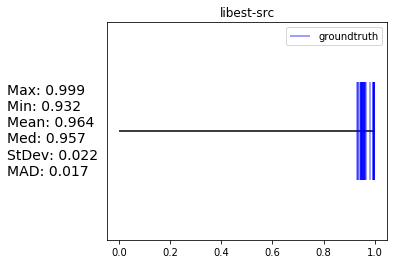

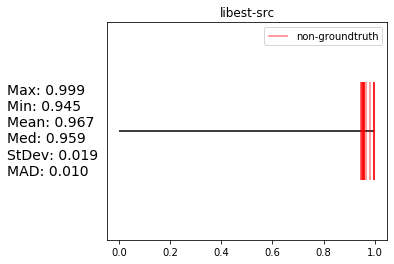

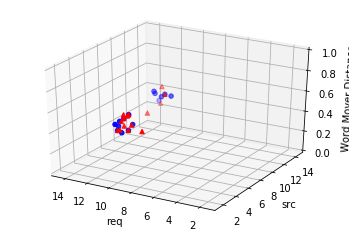

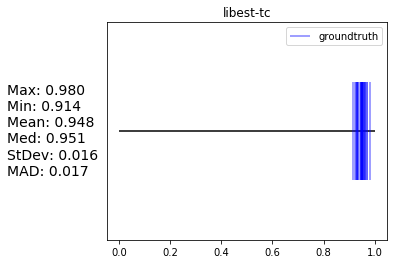

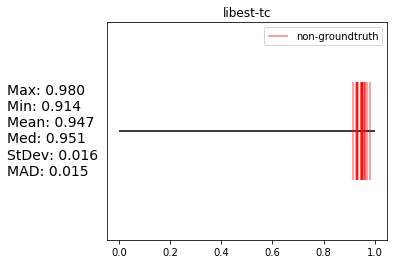

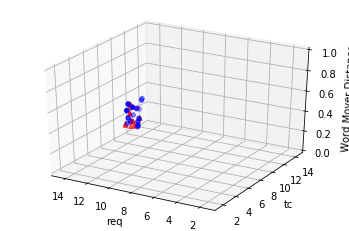

In [ ]:
entropy_visualize(links_wmd_df, non_links_wmd_df, nltk_vocab)

In [ ]:
links_wmd_df.head()

,sys,src_type,trgt_type,src_file,trgt_file,wmd,src_doc,trgt_doc
72,libest,req,src,RQ13.txt,est_locl.h,0.509546,requir protocol design layer figur provid expa...,libest test api void est log est log level lvl...
136,libest,req,src,RQ15.txt,est_server.c,0.405939,requir http layer http use transfer est messag...,function send est specif http error respons vo...
86,libest,req,src,RQ17.txt,est_locl.h,0.484459,requir http uri control est server must suppor...,libest test api void est log est log level lvl...
14,libest,req,src,RQ18.txt,est_server_http.c,0.471456,requir http base client authent est server may...,static pthread pthread self void return get cu...
139,libest,req,src,RQ19.txt,est_locl.h,0.506730,requir messag type document use exist media ty...,libest test api void est log est log level lvl...


In [ ]:
non_links_wmd_df.head()

,sys,src_type,trgt_type,src_file,trgt_file,wmd,src_doc,trgt_doc
0,libest,req,tc,RQ11.txt,us3496.c,0.533299,requir full pki request messag full pki reques...,unit test uri path segment extens support marc...
0,libest,req,tc,RQ14.txt,us899.c,0.317060,requir applic layer est client must capabl gen...,unit test user stori client simpl enrol septem...
0,libest,req,tc,RQ15.txt,us3612.c,0.512685,requir http layer http use transfer est messag...,unit test user stori encrypt privat key suppor...
0,libest,req,tc,RQ15.txt,us899.c,0.392408,requir http layer http use transfer est messag...,unit test user stori client simpl enrol septem...
0,libest,req,tc,RQ16.txt,us1159.c,0.431805,requir http header control http status valu us...,unit test user stori csr attribut enforc octob...


In [ ]:
entropy_visualize(links_wmd_df, non_links_wmd_df, nltk_vocab)

In [ ]:
entropy_benchmark(links_df, non_links_df, nltk_vocab, n = 0.1)


Source Datatype: req
Max: 12.347777849968535
Min: 10.018719807846903
Average: 11.642340628948059
Median: 11.946938038444188
Standard Deviation: 0.6904136822698144
Median Absolute Deviation: 0.4536184591798644
95% of the data fall within 11.45389396964201 and 11.830787288254108




Target Datatype: src
Max: 10.871732731601927
Min: 5.2404225771091095
Average: 6.97443948841153
Median: 6.1782282112064735
Standard Deviation: 2.064618239370149
Median Absolute Deviation: 0.6312334875889354
95% of the data fall within 5.947728992534182 and 8.001149984288878




Target Datatype: tc
Max: 9.03055398179956
Min: 6.611696965991225
Average: 7.44074190630927
Median: 7.134218056971649
Standard Deviation: 0.818551219109561
Median Absolute Deviation: 0.5344553128954183
95% of the data fall within 7.163784019710387 and 7.717699792908154




Total System Entropy
Max: 12.347777849968535
Min: 5.2404225771091095
Average: 9.46382419797904
Median: 10.127119384835542
Standard Deviation: 2.438686664616734
Median Absolute Deviation: 2.9965843887286865
95% of the data fall within 8.998632697076264 and 9.929015698881816



## Read in the data

In [ ]:
english_systems = {'libest': ['req', 'src', 'tc']}
italian_systems = {'albergate': ['req', 'src']}

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
def benchmark_testbed(gt, ngt, sys, data_type):
    gt = gt.loc[gt['sys'] == sys]
    ngt = ngt.loc[ngt['sys'] == sys]
    gt = gt.loc[gt['to_type'] == data_type]
    ngt = ngt.loc[ngt['to_type'] == data_type]
    
    gt_from = gt['from_doc'].sample(frac = 1).to_list()[:100]
    gt_to = gt['to_doc'].sample(frac = 1).to_list()[:100]
    gt_to_files = gt['to_file'].sample(frac = 1).to_list()[:100]
    gt_to_cnt = Counter()
    for file in gt_to_files:
        gt_to_cnt[file] += 1
    ngt_from = ngt['from_doc'].sample(frac = 1).to_list()[:100]
    ngt_to = ngt['to_doc'].sample(frac = 1).to_list()[:100]
    
    return gt_from, gt_to, gt_to_cnt, ngt_from, ngt_to

In [ ]:
def benchmark_metrics(from_docs, to_docs, vocab):
    from_entropies = get_entropies_from_docs(from_docs, vocab)
    to_entropies = get_entropies_from_docs(to_docs, vocab)

    shared_probs = [get_shared_probs_from_docs([[docs[0]], [docs[1]]], vocab)[0] for docs in zip(from_docs, to_docs)]
    
    return from_entropies, to_entropies, shared_probs

In [ ]:
def benchmark_visualize(gts, ngts, gt_to_cnt, sys, trgt_type):
    visualize_gt_ngt([gts[0], gts[1]], [ngts[0], ngts[1]], sys, trgt_type)
    visualize_events(gts[2], 'b', f'{sys}-{trgt_type}', 'groundtruth')
    visualize_events(ngts[2], 'r', f'{sys}-{trgt_type}', 'non-groundtruth')
    plot_counts(gt_to_cnt, 'File', 'Entropy', top_k = 5)

In [ ]:
def calc_entropy_benchmark(path, systems, lang, vocab):
    gt, ngt = gen_gt_ngt(path/'testbeds', lang)
    for sys in systems:
        print('System:', sys)
        
        sys_docs = []
        for data_type in systems[sys]:
            if data_type != 'req':
                gt_from, gt_to, gt_to_cnt, ngt_from, ngt_to = benchmark_testbed(gt, ngt, sys, data_type)
                gt_from_entropies, gt_to_entropies, gt_shared_probs = benchmark_metrics(gt_from, gt_to, vocab)
                ngt_from_entropies, ngt_to_entropies, ngt_shared_probs = benchmark_metrics(ngt_from, ngt_to, vocab)
                benchmark_visualize([gt_from_entropies, gt_to_entropies, gt_shared_probs],
                                    [ngt_from_entropies, ngt_to_entropies, ngt_shared_probs],
                                    gt_to_cnt, sys, data_type
                                   )
            
            data_path = path/'testbeds/bpe'/lang/sys/data_type
            sys_docs.append(read_bpe_files(data_path))
            entropies = get_entropies_from_docs(sys_docs[-1], vocab)

            print('Data Type:', data_type)
            report_stats(entropies)

            entropy = get_entropy_from_docs(sys_docs[-1], vocab)
            print('Total Corpus Entropy:', entropy)
            print()

        entropy = get_entropy_from_docs(flatten(sys_docs), vocab)
        print('Total System Entropy:', entropy)
        entropy = shared_entropy_from_docs(sys_docs, vocab)
        print('Shared Entropy:', entropy)
        shared_prob, shared_info_content = get_shared_probs_from_docs(sys_docs, vocab)
        print('Shared Relative Probability:', shared_prob)
#         print('Shared Information Content:', shared_info_content)
        print()

System: libest
Data Type: req
Max: 8.968470267401546
Min: 4.582118926162054
Average: 6.555639763272137
Median: 6.553373564799516
Standard Deviation: 0.9117247183020495
Median Absolute Deviation: 0.8106879130708909
95% of the data fall within 6.301813981075468 and 6.8094655454688064
Total Corpus Entropy: 9.531278857123576



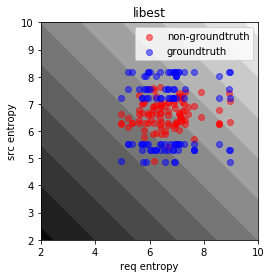

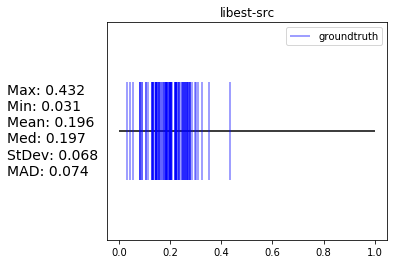

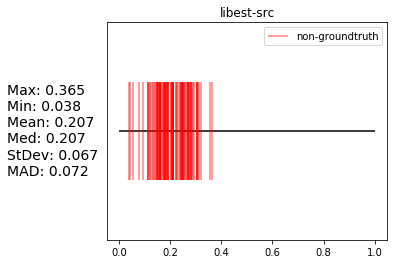

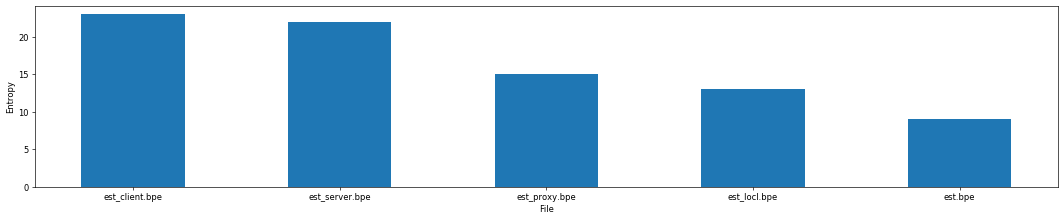

Data Type: src
Max: 8.173508989120867
Min: 4.004576449759752
Average: 6.173185702099091
Median: 5.518650040250094
Standard Deviation: 1.5678717563957953
Median Absolute Deviation: 2.2447655052609807
95% of the data fall within 4.968012784282179 and 7.378358619916003
Total Corpus Entropy: 8.23961374436026



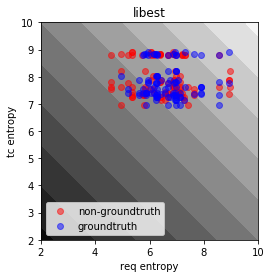

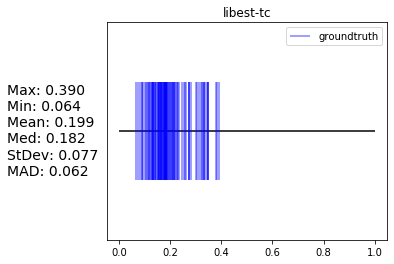

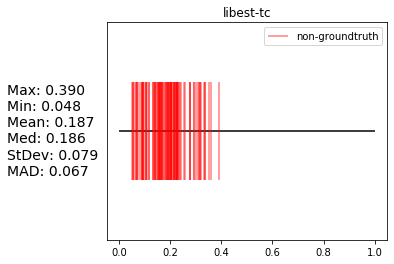

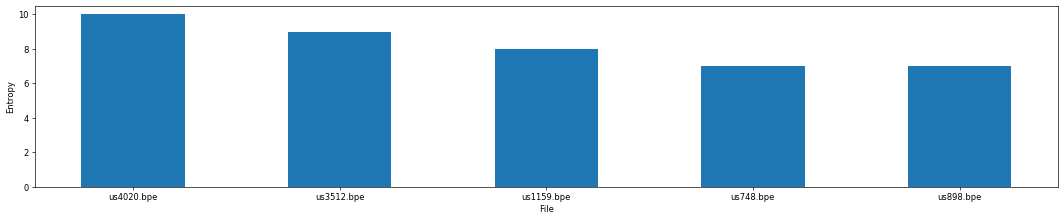

Data Type: tc
Max: 8.927136233104443
Min: 6.971154720309089
Average: 7.8501885481736915
Median: 7.632008464614358
Standard Deviation: 0.6303910678225148
Median Absolute Deviation: 0.4745742763599447
95% of the data fall within 7.563237974414906 and 8.137139121932478
Total Corpus Entropy: 8.667603560423398

Total System Entropy: 9.042034526069003
Shared Entropy: 7.056698690724442
Shared Relative Probability: 0.6280739300387688



In [ ]:
calc_entropy_benchmark(path, english_systems, 'english', vocab)

System: albergate
Data Type: req
Max: 7.4520861220022105
Min: 6.827008941199139
Average: 7.119302781397522
Median: 7.185263493475217
Standard Deviation: 0.1742674859024126
Median Absolute Deviation: 0.20017026343945338
95% of the data fall within 7.029702707959892 and 7.208902854835152
Total Corpus Entropy: 8.345303497433934



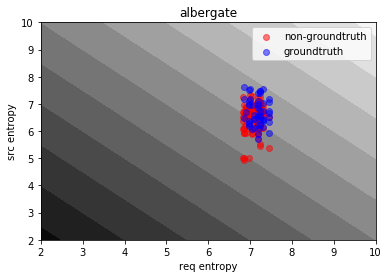

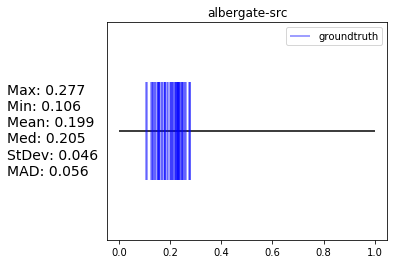

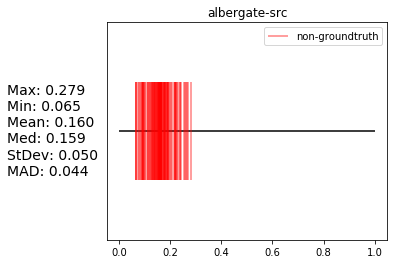

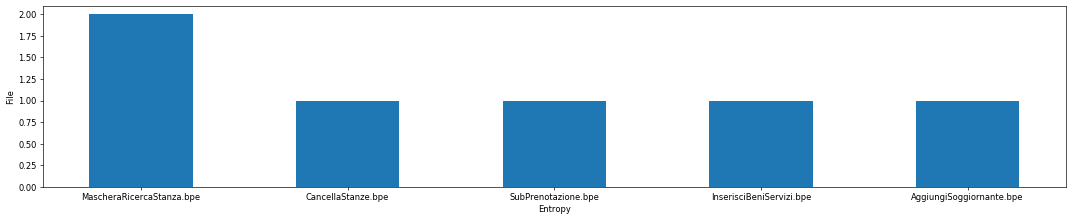

Data Type: src
Max: 7.633223137426075
Min: 5.703382875340349
Average: 6.699428963238912
Median: 6.587761126739944
Standard Deviation: 0.4730507714539506
Median Absolute Deviation: 0.5507863832484997
95% of the data fall within 6.571545426298444 and 6.82731250017938
Total Corpus Entropy: 8.025468102130741

Total System Entropy: 8.284356232866555
Shared Entropy: 5.637494860682083
Shared Relative Probability: 0.33083739781548266



In [ ]:
calc_entropy_benchmark(path, italian_systems, 'italian')

In [ ]:
def calc_entropy_benchmark_old(path, systems, lang, n_samps = 256):
    gt, ngt = gen_gt_ngt(path/'testbeds', lang)
    for sys in systems:
        gt_sys = gt.loc[gt['sys'] == sys]
        ngt_sys = ngt.loc[ngt['sys'] == sys]
        
        gt_from = gt_sys['from_doc'].sample(frac = 1).to_list()[:n_samps]
        gt_to = gt_sys['to_doc'].sample(frac = 1).to_list()[:n_samps]
        ngt_from = ngt_sys['from_doc'].sample(frac = 1).to_list()[:len(gt_from)]
        ngt_to = ngt_sys['to_doc'].sample(frac = 1).to_list()[:len(gt_to)]
        
        gt_from_entropies, gt_to_entropies, gt_shared_probs = benchmark_metrics(gt_from, gt_to)
        ngt_from_entropies, ngt_to_entropies, ngt_shared_probs = benchmark_metrics(ngt_from, ngt_to)
        
        print('System:', sys)
        visualize_gt_ngt([gt_from_entropies, gt_to_entropies], [ngt_from_entropies, ngt_to_entropies], sys, 'Source Code')
        visualize_events(gt_shared_probs, 'b', sys, 'groundtruth')
        visualize_events(ngt_shared_probs, 'r', sys, 'non-groundtruth')
        
        sys_docs = []
        for data_type in systems[sys]:
            data_path = path/'testbeds/bpe'/lang/sys/data_type
            sys_docs.append(read_bpe_files(data_path))
            entropies = get_entropies_from_docs(sys_docs[-1])

            print('Data Type:', data_type)
            report_stats(entropies)

            entropy = get_entropy_from_docs(sys_docs[-1])
            print('Total Corpus Entropy:', entropy)
            print()

        entropy = get_entropy_from_docs(flatten(sys_docs))
        print('Total System Entropy:', entropy)
        entropy = shared_entropy_from_docs(sys_docs)
        print('Shared Entropy:', entropy)
        shared_prob, shared_info_content = get_shared_probs_from_docs(sys_docs)
        print('Shared Relative Probability:', shared_prob)
#         print('Shared Information Content:', shared_info_content)
        print()

System: itrust


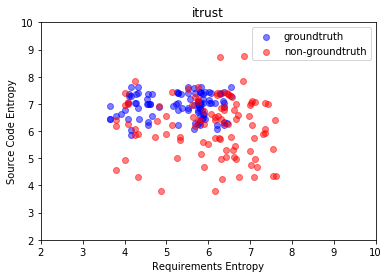

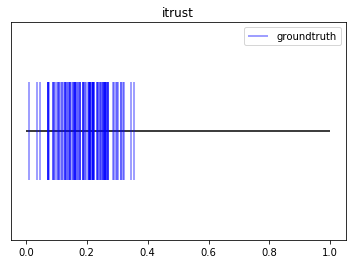

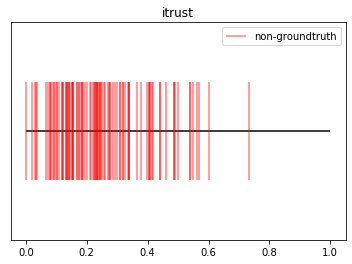

Data Type: req
Max: 6.655947403853904
Min: 3.6464393446710157
Average: 5.125309432616202
Median: 5.23890125660263
Standard Deviation: 0.7675282320547024
Median Absolute Deviation: 0.949724465856331
95% of the data fall within 4.992640720488694 and 5.25797814474371
Total Corpus Entropy: 8.138886303909846

Data Type: src
Max: 7.747087175535515
Min: 4.51364592935837
Average: 6.584188480250173
Median: 6.607110320868633
Standard Deviation: 0.5302214180761683
Median Absolute Deviation: 0.5515873888444468
95% of the data fall within 6.527031493101348 and 6.641345467398998
Total Corpus Entropy: 8.934418803418986

Total System Entropy: 9.009082050954651
Shared Entropy: 6.763812739263795
Shared Relative Probability: 0.47147080887868964

System: libest


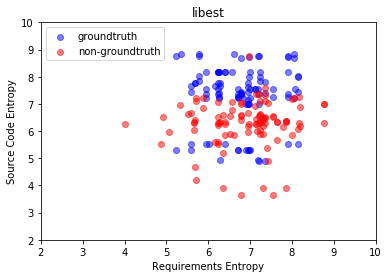

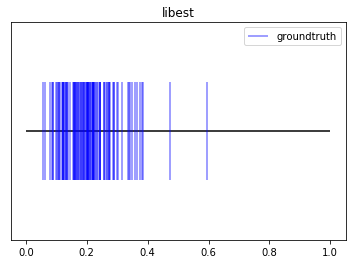

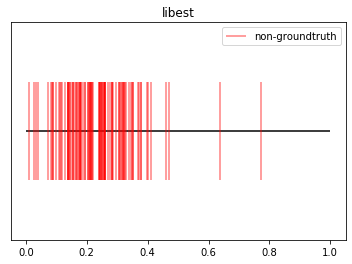

Data Type: req
Max: 8.133644403908326
Min: 4.694019357121934
Average: 6.543663643429754
Median: 6.5960839256764
Standard Deviation: 0.7998515650224864
Median Absolute Deviation: 0.8070430386925501
95% of the data fall within 6.3209835459644115 and 6.766343740895097
Total Corpus Entropy: 9.183085440385813

Data Type: src
Max: 8.16742303287423
Min: 4.004576449759753
Average: 6.177486953628029
Median: 5.523275682146648
Standard Deviation: 1.5603686286639487
Median Absolute Deviation: 2.251623481936811
95% of the data fall within 4.978081450336224 and 7.376892456919834
Total Corpus Entropy: 8.227602603165863

Data Type: tc
Max: 8.84281643986258
Min: 6.981127448895606
Average: 7.833269648196844
Median: 7.643609989333774
Standard Deviation: 0.5961050558091697
Median Absolute Deviation: 0.49366977593502526
95% of the data fall within 7.561925879993082 and 8.104613416400605
Total Corpus Entropy: 8.642622470130963

Total System Entropy: 8.990228755577743


KeyboardInterrupt: 

In [ ]:
calc_entropy_benchmark(path, english_systems, 'english', n_samps = 100)

System: albergate


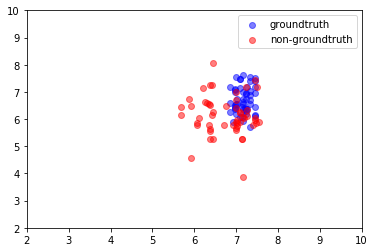

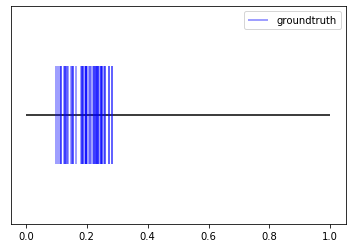

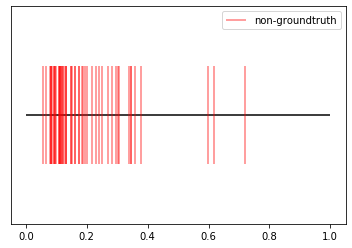

Data Type: req
Max: 7.451061154959707
Min: 6.7760271692033065
Average: 7.114662232676978
Median: 7.136128583124725
Standard Deviation: 0.18028670118666468
Median Absolute Deviation: 0.19215087521795687
95% of the data fall within 7.021967364311235 and 7.207357101042722
Total Corpus Entropy: 8.333064635075104

Data Type: src
Max: 7.632003142360006
Min: 5.694455777930451
Average: 6.698395952158591
Median: 6.585514345171939
Standard Deviation: 0.47533702601616074
Median Absolute Deviation: 0.5563741051053886
95% of the data fall within 6.569894354034409 and 6.826897550282773
Total Corpus Entropy: 8.02635009717346

Total System Entropy: 8.284551907349751
Shared Entropy: 5.704935783592468
Shared Relative Probability: 0.33135155648064085

System: ebt


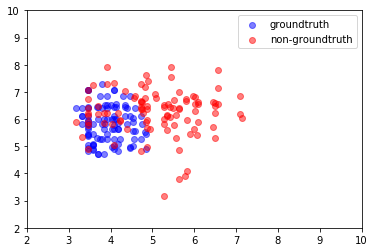

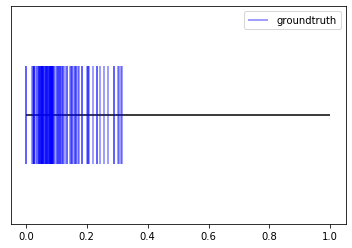

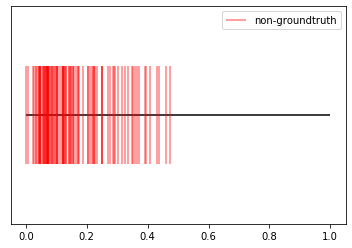

Data Type: req
Max: 4.85798099512757
Min: 3.169925001442312
Average: 4.036522483018428
Median: 4.037401197654112
Standard Deviation: 0.44238259432648075
Median Absolute Deviation: 0.49957908952600216
95% of the data fall within 3.896889307383322 and 4.176155658653533
Total Corpus Entropy: 6.78794959659894

Data Type: src
Max: 7.297368573550913
Min: 4.784576473149472
Average: 5.963495662337905
Median: 5.903977747837278
Standard Deviation: 0.633890544451061
Median Absolute Deviation: 0.7640379035089379
95% of the data fall within 5.783345963113105 and 6.143645361562706
Total Corpus Entropy: 8.433164216462012

Data Type: tc
Max: 6.097097085934414
Min: 4.704511459715548
Average: 5.247301653814626
Median: 5.281405982501043
Standard Deviation: 0.3692170341835723
Median Absolute Deviation: 0.4094487421886657
95% of the data fall within 5.094896352658618 and 5.399706954970633
Total Corpus Entropy: 7.081408121899548

Total System Entropy: 8.65824233434985
Shared Entropy: 5.006590016354143
Share

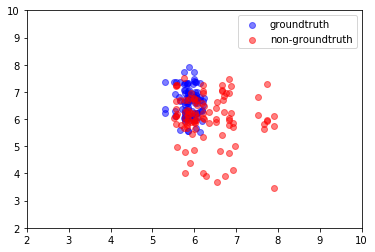

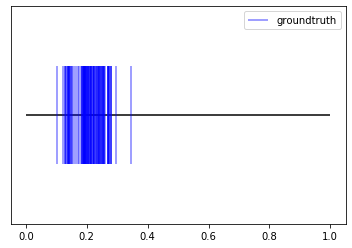

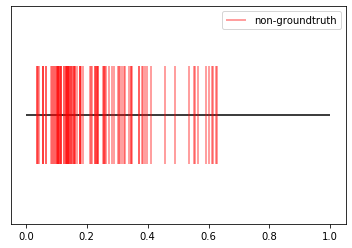

Data Type: req
Max: 6.237393834397654
Min: 5.29192090403933
Average: 5.852879032919364
Median: 5.845473100698095
Standard Deviation: 0.19175655109469367
Median Absolute Deviation: 0.18038957028930175
95% of the data fall within 5.802459218071263 and 5.903298847767465
Total Corpus Entropy: 7.10566459632011

Data Type: src
Max: 8.048968980820781
Min: 5.539696852908118
Average: 6.562921919889305
Median: 6.565193494077665
Standard Deviation: 0.541016209002899
Median Absolute Deviation: 0.5387698222061198
95% of the data fall within 6.463421809399394 and 6.662422030379217
Total Corpus Entropy: 8.74630095106817

Total System Entropy: 8.821970266170094
Shared Entropy: 5.822212387865012
Shared Relative Probability: 0.333506370324796

System: smos


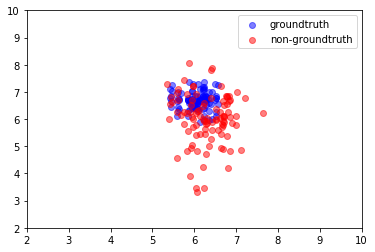

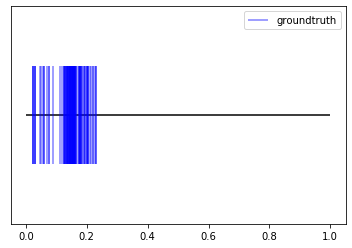

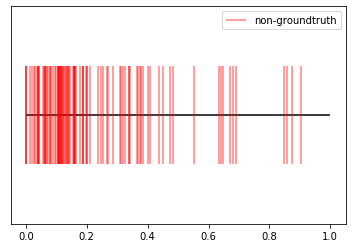

Data Type: req
Max: 6.620285755044159
Min: 5.400701696091559
Average: 6.117630402688541
Median: 6.14042834992966
Standard Deviation: 0.30288713322086697
Median Absolute Deviation: 0.2983853257033212
95% of the data fall within 6.043750425878531 and 6.191510379498552
Total Corpus Entropy: 7.39510779242834

Data Type: src
Max: 7.868448246363015
Min: 5.351552244391098
Average: 6.646037374067181
Median: 6.700747575555027
Standard Deviation: 0.46042397977922234
Median Absolute Deviation: 0.354721814886772
95% of the data fall within 6.554679267511279 and 6.737395480623084
Total Corpus Entropy: 8.357381483417843

Total System Entropy: 8.595914118672756
Shared Entropy: 5.660800120573564
Shared Relative Probability: 0.3023618380424987



In [ ]:
calc_entropy_benchmark(path, italian_systems, 'italian', n_samps = 100)

# SCRATCH WORK

In [ ]:
def entropy_metric(gt, ngt, vocab, n = 1):
#     gt = gt.sample(frac = n)
#     ngt = ngt.sample(frac = n)
    
    src_dtypes = gt.src_type.unique()
    src_docs = [(dtype, gt.loc[gt.src_type == dtype].src_doc.values)for dtype in src_dtypes]
#     for dtype, docs in src_docs:
#         e = get_entropies_from_docs(docs, vocab)
#         print(f'Source Datatype: {dtype}')
#         report_stats(e)
#         print()
    
    trgt_dtypes = gt.trgt_type.unique()
    trgt_docs = [(dtype, gt.loc[gt.trgt_type == dtype].trgt_doc.values) for dtype in trgt_dtypes]
#     for dtype, docs in trgt_docs:
#         e = get_entropies_from_docs(docs, vocab)
#         print(f'Target Datatype: {dtype}')
#         report_stats(e)
#         print()
    
    for src_dtype in src_dtypes:
        for trgt_dtype in trgt_dtypes:
            gt_docs_src = gt.loc[gt.src_type == src_dtype].loc[gt.trgt_type == trgt_dtype].src_doc.values
            gt_docs_trgt = gt.loc[gt.src_type == src_dtype].loc[gt.trgt_type == trgt_dtype].trgt_doc.values
            gt_src_entropies = get_entropies_from_docs(gt_docs_src, vocab)[:15]
            gt_trgt_entropies = get_entropies_from_docs(gt_docs_trgt, vocab)[:15]
            gt_wmds = gt.loc[gt.src_type == 'req'].loc[gt.trgt_type == 'src'].wmd.values[:15]

            ngt_docs_src = ngt.loc[ngt.src_type == src_dtype].loc[ngt.trgt_type == trgt_dtype].src_doc.values
            ngt_docs_trgt = ngt.loc[ngt.src_type == src_dtype].loc[ngt.trgt_type == trgt_dtype].trgt_doc.values
            ngt_src_entropies = get_entropies_from_docs(ngt_docs_src, vocab)[:15]
            ngt_trgt_entropies = get_entropies_from_docs(ngt_docs_trgt, vocab)[:15]
            ngt_wmds = ngt.loc[ngt.src_type == 'req'].loc[ngt.trgt_type == 'src'].wmd.values[:15]
            vis_3d(
                [gt_src_entropies, gt_trgt_entropies, gt_wmds],
                [ngt_src_entropies, ngt_trgt_entropies, ngt_wmds],
                src_dtype, trgt_dtype
            )
#             entropy_vis_gt_ngt([gt_src_entropies, gt_trgt_entropies], [ngt_src_entropies, ngt_trgt_entropies], 'libest', trgt_dtype)
    
#     all_docs = [docs for _, docs in src_docs + trgt_docs]
#     entropy = get_entropy_from_docs(flatten(all_docs), vocab)
#     print(f'Total System Entropy:', entropy)
#     entropy = shared_entropy_from_docs(all_docs, vocab)
#     print('Shared Entropy:', entropy)
#     shared_prob, shared_info_content = get_shared_probs_from_docs(all_docs, vocab)
#     print('Shared Relative Probability:', shared_prob)

In [ ]:
gt_english, ngt_english = gen_gt_ngt(path/'testbeds', 'english')

In [ ]:
gt_english.head()

,sys,from_type,to_type,from_file,to_file,from_doc,to_doc
0,itrust,req,src,UC10E1.bpe,getUser.bpe,"[▁The, ▁health, ▁care, ▁professional, ▁types, ...","[▁<%@, ▁page, ▁import, ="", java, ., net, ., UR..."
1,itrust,req,src,UC10E1.bpe,GetUserNameAction.bpe,"[▁The, ▁health, ▁care, ▁professional, ▁types, ...","[▁p, ackage, ▁edu, ., nc, su, ., cs, c, ., itr..."
2,itrust,req,src,UC10E1.bpe,AuthDAO.bpe,"[▁The, ▁health, ▁care, ▁professional, ▁types, ...","[▁p, ackage, ▁edu, ., nc, su, ., cs, c, ., itr..."
3,itrust,req,src,UC10E2.bpe,getUser.bpe,"[▁The, ▁patient, ▁cho, sen, ▁is, ▁not, ▁the, ▁...","[▁<%@, ▁page, ▁import, ="", java, ., net, ., UR..."
4,itrust,req,src,UC10E2.bpe,GetUserNameAction.bpe,"[▁The, ▁patient, ▁cho, sen, ▁is, ▁not, ▁the, ▁...","[▁p, ackage, ▁edu, ., nc, su, ., cs, c, ., itr..."


In [ ]:
ngt_english.head()

,sys,from_type,to_type,from_file,to_file,from_doc,to_doc
0,libest,req,src,RQ7.bpe,est_locl.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁, LIB, EST, _, TEST, _, API, ▁void, ▁est, _,..."
1,libest,req,src,RQ7.bpe,est.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁/**, ▁@, file, ▁*/, ▁/*, --, ---------------..."
2,libest,req,src,RQ7.bpe,est_proxy.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁/*, ▁*, ▁S, ince, ▁we, ▁, hij, ack, ▁the, ▁O..."
3,libest,req,src,RQ7.bpe,est_client_proxy.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁t, cw, _, err, _, t, ▁t, cw, _, connect, (, ..."
4,libest,req,src,RQ7.bpe,est_ossl_util.bpe,"[▁, REQUIRE, MENT, ▁, 7, :, ▁CERTIFICATE, -, L...","[▁int, ▁ossl, _, verify, _, cb, (, int, ▁ok, ,..."


In [ ]:
sample_gt_from_en = gt_english['from_doc'].sample(frac = 0.1).to_list()
sample_gt_to_en = gt_english['to_doc'].sample(frac = 0.1).to_list()

In [ ]:
sample_ngt_from_en = ngt_english['from_doc'].sample(frac = 0.1).to_list()
sample_ngt_to_en = ngt_english['to_doc'].sample(frac = 0.1).to_list()

In [ ]:
gt_from_entropies = get_entropies_from_docs(sample_gt_from_en)
gt_to_entropies = get_entropies_from_docs(sample_gt_to_en)

In [ ]:
ngt_from_entropies = get_entropies_from_docs(sample_ngt_from_en)
ngt_to_entropies = get_entropies_from_docs(sample_ngt_to_en)

In [ ]:
gt_shared_probs = [get_shared_probs_from_docs(docs)[0] for docs in zip(sample_gt_from_en, sample_gt_to_en)]
ngt_shared_probs = [get_shared_probs_from_docs(docs)[0] for docs in zip(sample_ngt_from_en, sample_ngt_to_en)]

In [ ]:
import matplotlib.pyplot as plt

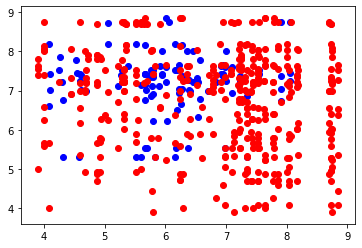

In [ ]:
plt.scatter(gt_from_entropies, gt_to_entropies, c='b')
plt.scatter(ngt_from_entropies, ngt_to_entropies, c='r')
plt.show()

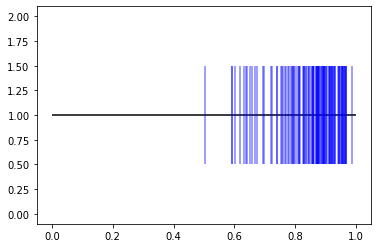

In [ ]:
plt.hlines(1,0,1)  # Draw a horizontal line
plt.eventplot(gt_shared_probs, orientation='horizontal', colors='b', alpha = 0.5)
# plt.margins(x=5, y=5)
plt.show()

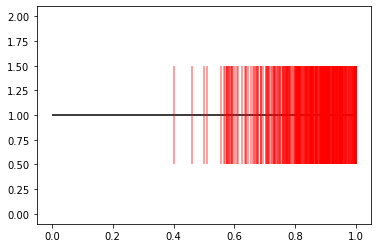

In [ ]:
plt.hlines(1,0,1)  # Draw a horizontal line
plt.eventplot(ngt_shared_probs, orientation='horizontal', colors='r', alpha = 0.5)
plt.show()

In [ ]:
for language in languages:
    req_fns = list((path/'datasets'/language).glob('**/*req]'))
    src_fns = list((path/'datasets'/language).glob('**/*src]'))
    tst_fns = list((path/'datasets'/language).glob('**/*tc]'))
    
    spm = sp.SentencePieceProcessor()
    spm.Load(str((path/'datasets'/language/f"{model_name}_bpe.model"))\
    
    all_fns = flatten(req_fns + src_fns + tst_fns)
    all_docs = tokenize_fns(all_fns, spm)

In [ ]:
req_fns = list((path/'datasets/english').glob('**/*req]'))
src_fns = list((path/'datasets/english').glob('**/*src]'))
tst_fns = list((path/'datasets/english').glob('**/*tc]'))
req_fns[:5], src_fns[:5], tst_fns[:5]

([PosixPath('../benchmarking/traceability/datasets/english/libest/[libest-raw-req]'),
  PosixPath('../benchmarking/traceability/datasets/english/itrust/[itrust-raw-req]')],
 [PosixPath('../benchmarking/traceability/datasets/english/libest/[libest-raw-src]'),
  PosixPath('../benchmarking/traceability/datasets/english/itrust/[itrust-raw-src]')],
 [PosixPath('../benchmarking/traceability/datasets/english/libest/[libest-raw-tc]')])

In [ ]:
all_fns = flatten(req_fns + src_fns + tst_fns)
all_docs = tokenize_fns(all_fns, spm)

In [ ]:
req_docs = 

In [ ]:
src_fns[0].parent.name

'libest'

In [ ]:
list(path.glob('datasets/italian/*/*'))

[PosixPath('../benchmarking/traceability/datasets/italian/smos/[smos-raw-src]'),
 PosixPath('../benchmarking/traceability/datasets/italian/smos/[smos-raw-req]'),
 PosixPath('../benchmarking/traceability/datasets/italian/smos/[smos-all].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/albergate/[albergate-all].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/albergate/[albergate-raw-src]'),
 PosixPath('../benchmarking/traceability/datasets/italian/albergate/[albergate-raw-req]'),
 PosixPath('../benchmarking/traceability/datasets/italian/ebt/[ebt-all].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/ebt/[ebt-raw-src]'),
 PosixPath('../benchmarking/traceability/datasets/italian/ebt/[ebt-raw-tc].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/ebt/[ebt-raw-req].txt'),
 PosixPath('../benchmarking/traceability/datasets/italian/etour/[etour-raw-src]'),
 PosixPath('../benchmarking/traceability/datasets/italian/etour/[etour-raw-req

In [ ]:
def get_dtypes_entropy(df, dtypes, vocab):
    entropies = []
    for dtype in dtypes:
        docs = df.loc[df.dtype == dtype].doc.values
        entropies.append(get_entropies_from_docs(docs, vocab))
    
    return entropies

In [ ]:
def entropy_benchmark(gt, ngt, vocab, n = 1):
    gt = gt.sample(frac = n)
    ngt = ngt.sample(frac = n)
    
#     src_docs = [(dtype, gt.loc[gt.src_type == dtype].src_doc.values)for dtype in gt.src_type.unique()]
#     for dtype, docs in src_docs:
#         e = get_entropies_from_docs(docs, vocab)
#         print(f'Source Datatype: {dtype}')
#         report_stats(e)
#         print()
        
#     trgt_docs = [(dtype, gt.loc[gt.trgt_type == dtype].trgt_doc.values) for dtype in gt.trgt_type.unique()]
#     for dtype, docs in trgt_docs:
#         e = get_entropies_from_docs(docs, vocab)
#         print(f'Target Datatype: {dtype}')
#         report_stats(e)
#         print()
        
    src_df = gt[['src_type', 'src_doc']].copy().rename(columns = {'src_type': 'dtype', 'src_doc': 'doc'})
    src_dtypes = src_df.dtype.unique()
    entropies = get_dtypes_entropy(src_df, src_df.dtype.unique(), vocab)
    for e, dtype in zip(entropies, src_dtypes):
        print(f'Source Datatype: {dtype}')
        report_stats(e)
        print()
    
    trgt_df = gt[['trgt_type', 'trgt_doc']].copy().rename(columns = {'trgt_type': 'dtype', 'trgt_doc': 'doc'})
    trgt_dtypes = trgt_df.dtype.unique()
    entropies = get_dtypes_entropy(trgt_df, trgt_dtypes, vocab)
    for e, dtype in zip(entropies, trgt_dtypes):
        print(f'Target Datatype: {dtype}')
        report_stats(e)
        print()
    
#     all_docs = src_df.doc.values
#     entropies = get_entropies_from_docs(all_docs, vocab)
#     print(f'Total System Entropy')
#     report_stats(entropies)
#     print()

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 0.0_mgmnt.prep.i.ipynb.
Converted 0.1_mgmnt.prep.conv.ipynb.
Converted 0.2_mgmnt.db.mongo.ipynb.
Converted 0.3_mgmnt.prep.bpe.ipynb.
Converted 0.4_mgmnt.corpus.ipynb.
Converted 0.5_mgmnt.prep.traceability.ipynb.
Converted 0.6_mgmnt.prep.nltk.ipynb.
Converted 1.0_exp.i.ipynb.
Converted 1.1_exp.info.ipynb.
Converted 1.2_exp.csnc.ipynb.
Converted 1.3_exp.csnc_python.ipynb.
Converted 2.0_repr.i.ipynb.
Converted 2.1_repr.codeberta.ipynb.
Converted 2.1_repr.roberta.train.ipynb.
Converted 2.2_repr.roberta.eval.ipynb.
Converted 2.3_repr.word2vec.train.ipynb.
Converted 2.6_repr.word2vec.eval.ipynb.
Converted 2.7_repr.distmetrics.ipynb.
Converted 3.0_mining.unsupervised.traceability.ida.ipynb.
Converted 3.1_mining.unsupervised.traceability.eda.ipynb.
Converted 3.2_mining.unsupervised.traceability.approach.ipynb.
Converted 3.2_mining.unsupervised.traceability.approach[cisco].ipynb.
Converted 3.3_mining.unsupervised.traceability.eval.ipynb.
Converted 4.0_benchmark.i.ipynb.
Converted 4.1_